<div class="alert alert-block alert-info">
<div style="text-align: center"><h1>Equitable Distribution of Foreign Aid</h1></div>

<div style="text-align: center"><img src="world_map_pie_chart.jpg" width=25% /></div>

***
# Introduction
Poverty is a complex issue often resulting from a combination of factors beyond the individual's control such as conflict, institutional corruption, climate, and economic and health policies. Historically, wealthier, developed nations have taken on the responsibility of providing resources to aid low-middle income countries. Aid can take the form of military, economic or humanitarian aid with the aim of improving safety, infrastructure, health and other basic human needs, sustainably. One of the many challenges faced is how to optimise aid distribution for lasting, positive change.

# About the dataset
A dataset<sup>__[1](https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data/data)__</sup> of socio-economic and health data (period unknown) from 167 countries.<br>


10 features:<br>
**country:**	Name of country<br>
**child_mort:**	Death of children under 5 years of age per 1,000 live births<br>
**exports:**	Exports of goods and services (% GDP per capita)<br>
**health:** 	Total health spending (% GDP per capita)<br>
**imports:**	Imports of goods and services (% GDP per capita)<br>
**Income:** 	Net income per capita ($US)<br>
**Inflation:**	The measurement of the annual growth rate of the GDP<br>
**life_expec:**	The average number of years a new born child would live if the current mortality patterns are to remain the same<br>
**total_fer:**	The number of children that would be born to each woman if the current age-fertility rates remain the same<br>
**gdpp:**   	The GDP per capita ($US).<br>

#### Conspicuously, several indicators such as population, literacy/education, women's health and environmental/energy are absent from the dataset.<br>
#### The included features of this dataset appear more focussed on <u>infant health & mortality</u>, given economic indicators.<br>

# Project objective
Identify countries most in need of foreign (financial) aid for infant health, by clustering based on socio-economic and health data.<br>

# Methodology
Following exploratory data analysis to understand feature relationships and best/worst countries for each feature, the data was pruned (26 economically wealthy countries with low infant mortality were removed). Univariate and multivariate analyses were reinvestigated to determine important features and feature engineering before clustering by KMeans.

# Main findings
Unsurprisingly, infant mortality, life expectancy and birth rate show strong correlations, as do imports with exports.<br>

Surprisingly, health spending does not correlate strongly with GDP, income or life expectancy (_i.e._, amount spent on health is irrespective of GPD/income, and was not consistently reflected in a corresponding life expectancy).<br>

Countries with high 'Exports', 'Income', 'Health_Spend' and 'GDPpC' and low infant mortality (< 5), are not normally associated with requiring foreign financial aid.<br>

The results of KMeans clustering suggest there are 127 countries (90%) classed as Priority Financial Aid when using 7 features (X_all) compared to 78 countries (55%) when using just two features (GDPpC & Birth_Rate; X_2).<br>

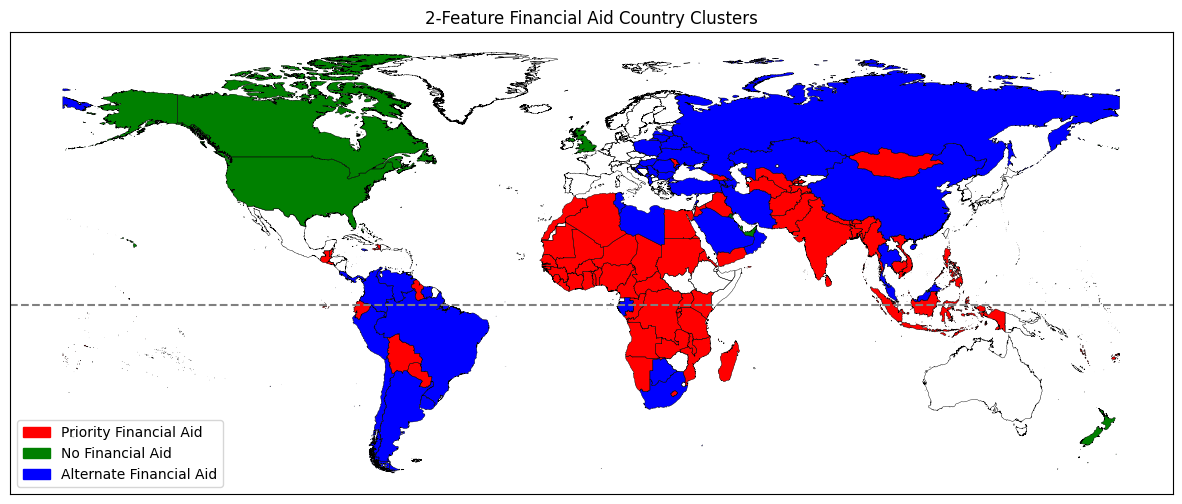

Using only two features for KMeans clustering yields a more interpretable and manageable result to facilitate decisions on financial aid distribution for infant health.

# Conclusions & future directions
Prioritising countries for foreign aid is a complex task requiring the consideration of a multitude of factors and expert domain knowledge.<br>
The results of this analysis can be used as a first step in refining which countries are in urgent need of financial aid by performing further analyses (such as DBSCAN or Hierachical clustering) on the Priority Financial Aid (cluster '0') countries.

***
***
# The code

In [1]:
from pandas import read_csv, set_option, DataFrame
from geopandas import read_file
from matplotlib.pyplot import subplots, show
from matplotlib.patches import Patch
from seaborn import pairplot, heatmap, kdeplot
from numpy import corrcoef, fill_diagonal,triu_indices, round, cumsum

from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from scipy.cluster import hierarchy

# Dataset inspection

In [2]:
set_option('display.max_columns', None)  # Force Pandas to show/display all columns of dataframe

countries_df = read_csv('country.csv')

print(countries_df.shape)
print(countries_df.columns)
countries_df.head()


(167, 10)
Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')


country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200

In [3]:
# Let's take a gander
print(countries_df[(countries_df['country'] == 'United Kingdom')])
print(countries_df[(countries_df['country'] == 'Sweden')])
countries_df[(countries_df['country'] == 'Australia')]

            country  child_mort  exports  health  imports  income  inflation  \
158  United Kingdom         5.2     28.2    9.64     30.8   36200       1.57   

     life_expec  total_fer   gdpp  
158        80.3       1.92  38900  
    country  child_mort  exports  health  imports  income  inflation  \
144  Sweden         3.0     46.2    9.63     40.7   42900      0.991   

     life_expec  total_fer   gdpp  
144        81.5       1.98  52100  


country  child_mort  exports  health  imports  income  inflation  \
7  Australia         4.8     19.8    8.73     20.9   41400       1.16   

   life_expec  total_fer   gdpp  
7        82.0       1.93  51900

<div class="alert alert-block alert-info">
Ah, the days of low inflation! When was this data from?

In [4]:
countries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


<div class="alert alert-block alert-info">
Except for 'country', all features are numerical.<br>
No apparent missing values, but let's check the usual ways...

In [5]:
# Check for missing/NaN values
countries_df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [6]:
# Check for missing values defaulting to 0.0
(countries_df==0.0).sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [7]:
# Check for row duplication
countries_df.duplicated().sum()

np.int64(0)

No row duplication.

In [8]:
# Check the state of the wolrd!
countries_df.describe().round(2)

child_mort  exports  health  imports     income  inflation  life_expec  \
count      167.00   167.00  167.00   167.00     167.00     167.00      167.00   
mean        38.27    41.11    6.82    46.89   17144.69       7.78       70.56   
std         40.33    27.41    2.75    24.21   19278.07      10.57        8.89   
min          2.60     0.11    1.81     0.07     609.00      -4.21       32.10   
25%          8.25    23.80    4.92    30.20    3355.00       1.81       65.30   
50%         19.30    35.00    6.32    43.30    9960.00       5.39       73.10   
75%         62.10    51.35    8.60    58.75   22800.00      10.75       76.80   
max        208.00   200.00   17.90   174.00  125000.00     104.00       82.80   

       total_fer       gdpp  
count     167.00     167.00  
mean        2.95   12964.16  
std         1.51   18328.70  
min         1.15     231.00  
25%         1.80    1330.00  
50%         2.41    4660.00  
75%         3.88   14050.00  
max         7.49  105000.00

In [9]:
# Rename features/columns

col_names = {'country': 'Country',
             'child_mort': 'Infant_Mortality',
             'exports': 'Exports',
             'health': 'Health_Spend',
             'imports': 'Imports',
             'income': 'Income',
             'inflation': 'Inflation',
             'life_expec': 'Life_Expectancy',
             'total_fer': 'Birth_Rate',
             'gdpp': 'GDPpC'
             }

countries_df.rename(columns=col_names, inplace=True)

# Verfiy changes
countries_df.columns

Index(['Country', 'Infant_Mortality', 'Exports', 'Health_Spend', 'Imports',
       'Income', 'Inflation', 'Life_Expectancy', 'Birth_Rate', 'GDPpC'],
      dtype='object')

# Univariate analyses

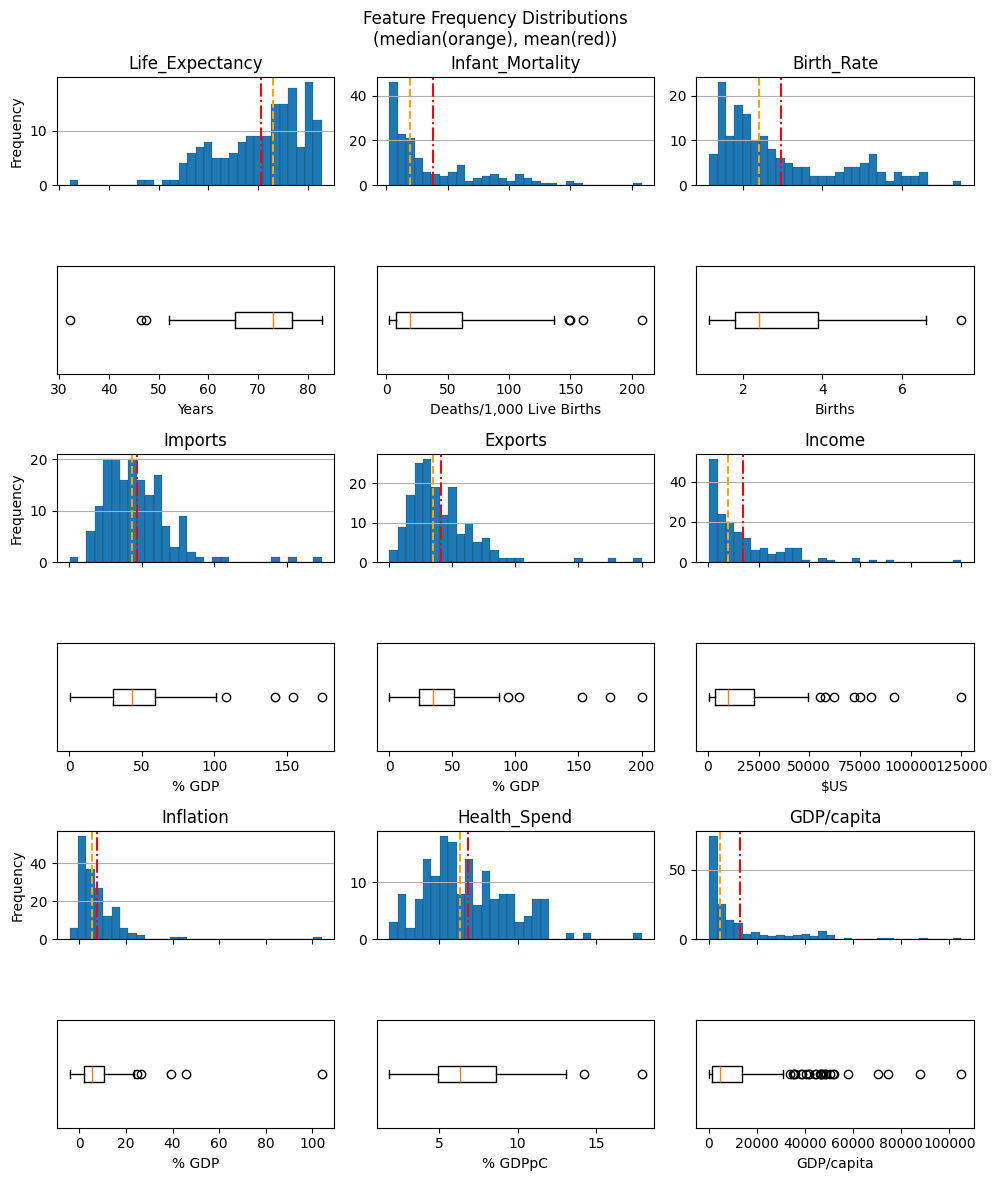

In [10]:
# Feature distribution

n_rows = 6
n_cols = 3
n_bins = 30
line_width = 0.1
edge_colour = 'k'

fig, ax  = subplots(nrows=n_rows, ncols=n_cols, figsize=(10,12))

ax[0,0].hist(countries_df['Life_Expectancy'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[0,0].axvline(countries_df['Life_Expectancy'].mean(), linestyle='-.', c='r')
ax[0,0].axvline(countries_df['Life_Expectancy'].median(), linestyle='--', c='orange')
ax[0,0].grid(visible=True, axis='y')
# ax[0,0].set_xlabel('Years')
ax[0,0].set_xticklabels([])
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_title('Life_Expectancy')
ax[1,0].boxplot(countries_df['Life_Expectancy'], vert=False)
ax[1,0].set_yticks([])
ax[1,0].set_xlabel('Years')

ax[0,1].hist(countries_df['Infant_Mortality'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[0,1].axvline(countries_df['Infant_Mortality'].mean(), linestyle='-.', c='r')
ax[0,1].axvline(countries_df['Infant_Mortality'].median(), linestyle='--', c='orange')
# ax[0,1].set_xlabel('Deaths/1,000 Live Births')
ax[0,1].set_xticklabels([])
ax[0,1].grid(visible=True, axis='y')
ax[0,1].set_title('Infant_Mortality')
ax[1,1].boxplot(countries_df['Infant_Mortality'], vert=False)
ax[1,1].set_yticks([])
ax[1,1].set_xlabel('Deaths/1,000 Live Births')

ax[0,2].hist(countries_df['Birth_Rate'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[0,2].axvline(countries_df['Birth_Rate'].mean(), linestyle='-.', c='r')
ax[0,2].axvline(countries_df['Birth_Rate'].median(), linestyle='--', c='orange')
# ax[0,2].set_xlabel('Births')
ax[0,2].set_xticklabels([])
ax[0,2].grid(visible=True, axis='y')
ax[0,2].set_title('Birth_Rate')
ax[1,2].boxplot(countries_df['Birth_Rate'], vert=False)
ax[1,2].set_yticks([])
ax[1,2].set_xlabel('Births')

ax[2,0].hist(countries_df['Imports'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[2,0].axvline(countries_df['Imports'].mean(), linestyle='-.', c='r')
ax[2,0].axvline(countries_df['Imports'].median(), linestyle='--', c='orange')
ax[2,0].grid(visible=True, axis='y')
ax[2,0].set_xticklabels([])
# ax[2,0].set_xlabel('% GDP')
ax[2,0].set_ylabel('Frequency')
ax[2,0].set_title('Imports')
ax[3,0].boxplot(countries_df['Imports'], vert=False)
ax[3,0].set_yticks([])
ax[3,0].set_xlabel('% GDP')

ax[2,1].hist(countries_df['Exports'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[2,1].axvline(countries_df['Exports'].mean(), linestyle='-.', c='r')
ax[2,1].axvline(countries_df['Exports'].median(), linestyle='--', c='orange')
ax[2,1].grid(visible=True, axis='y')
ax[2,1].set_xticklabels([])
# ax[2,1].set_xlabel('% GDP')
ax[2,1].set_title('Exports')
ax[3,1].boxplot(countries_df['Exports'], vert=False)
ax[3,1].set_yticks([])
ax[3,1].set_xlabel('% GDP')

ax[2,2].hist(countries_df['Income'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[2,2].axvline(countries_df['Income'].mean(), linestyle='-.', c='r')
ax[2,2].axvline(countries_df['Income'].median(), linestyle='--', c='orange')
ax[2,2].grid(visible=True, axis='y')
ax[2,2].set_xticklabels([])
# ax[2,2].set_xlabel('$US')
ax[2,2].set_title('Income')
ax[3,2].boxplot(countries_df['Income'], vert=False)
ax[3,2].set_yticks([])
ax[3,2].set_xlabel('$US')

ax[4,0].hist(countries_df['Inflation'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[4,0].axvline(countries_df['Inflation'].mean(), linestyle='-.', c='r')
ax[4,0].axvline(countries_df['Inflation'].median(), linestyle='--', c='orange')
ax[4,0].grid(visible=True, axis='y')
ax[4,0].set_ylabel('Frequency')
ax[4,0].set_xticklabels([])
# ax[4,0].set_xlabel('% GDP')
ax[4,0].set_title('Inflation')
ax[5,0].boxplot(countries_df['Inflation'], vert=False)
ax[5,0].set_yticks([])
ax[5,0].set_xlabel('% GDP')

ax[4,1].hist(countries_df['Health_Spend'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[4,1].axvline(countries_df['Health_Spend'].mean(), linestyle='-.', c='r')
ax[4,1].axvline(countries_df['Health_Spend'].median(), linestyle='--', c='orange')
ax[4,1].grid(visible=True, axis='y')
ax[4,1].set_xticklabels([])
# ax[4,1].set_xlabel('% GDPpC')
ax[4,1].set_title('Health_Spend')
ax[5,1].boxplot(countries_df['Health_Spend'], vert=False)
ax[5,1].set_yticks([])
ax[5,1].set_xlabel('% GDPpC')

ax[4,2].hist(countries_df['GDPpC'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[4,2].axvline(countries_df['GDPpC'].mean(), linestyle='-.', c='r')
ax[4,2].axvline(countries_df['GDPpC'].median(), linestyle='--', c='orange')
ax[4,2].grid(visible=True, axis='y')
ax[4,2].set_xticklabels([])
# ax[4,2].set_xlabel('GDP/capita')
ax[4,2].set_title('GDP/capita')
ax[5,2].boxplot(countries_df['GDPpC'], vert=False)
ax[5,2].set_yticks([])
ax[5,2].set_xlabel('GDP/capita')

fig.suptitle('Feature Frequency Distributions\n(median(orange), mean(red))')
fig.tight_layout()

<div class="alert alert-block alert-info">
<h4>There are some outliers. Countries with high 'Exports', 'Income', 'Health_Spend' and 'GDPpC' are unlikely to be in need of foreign financial aid.<h4>

In [11]:
# Which are the 'Exports' outliers?

# countries_df[countries_df['Exports'] >= 150].sort_values(by='Exports', ascending=False)
countries_df.sort_values(by='Exports', ascending=False).head()

Country  Infant_Mortality  Exports  Health_Spend  Imports  Income  \
133   Singapore               2.8    200.0          3.96    174.0   72100   
91   Luxembourg               2.8    175.0          7.77    142.0   91700   
98        Malta               6.8    153.0          8.65    154.0   28300   
73      Ireland               4.2    103.0          9.19     86.5   45700   
131  Seychelles              14.4     93.8          3.40    108.0   20400   

     Inflation  Life_Expectancy  Birth_Rate   GDPpC  
133     -0.046             82.7        1.15   46600  
91       3.620             81.3        1.63  105000  
98       3.830             80.3        1.36   21100  
73      -3.220             80.4        2.05   48700  
131     -4.210             73.4        2.17   10800

<div class="alert alert-block alert-info">
<h4>Although Malta and Seychelles enjoy high exports, they have higher infant mortality compared to Singapore, Luxembourg and Ireland - countries not normally associated with requiring foreign financial aid.<h4>

In [12]:
# Which are the 'Income' outliers?

countries_df[countries_df['Income'] > 50_000].sort_values(by='Income', ascending=False)

Country  Infant_Mortality  Exports  Health_Spend  Imports  \
123                 Qatar               9.0     62.3          1.81     23.8   
91             Luxembourg               2.8    175.0          7.77    142.0   
23                 Brunei              10.5     67.4          2.84     28.0   
82                 Kuwait              10.8     66.7          2.63     30.4   
133             Singapore               2.8    200.0          3.96    174.0   
114                Norway               3.2     39.7          9.48     28.5   
157  United Arab Emirates               8.6     77.7          3.66     63.6   
145           Switzerland               4.5     64.0         11.50     53.3   

     Income  Inflation  Life_Expectancy  Birth_Rate   GDPpC  
123  125000      6.980             79.5        2.07   70300  
91    91700      3.620             81.3        1.63  105000  
23    80600     16.700             77.1        1.84   35300  
82    75200     11.200             78.2        2.21   38500  
133   72100     -0.046             82.7        1.15   46600  
114   62300      5.950             81.0        1.95   87800  
157   57600     12.500             76.5        1.87   35000  
145   55500      0.317             82.2        1.52   74600

In [13]:
# Which are the 'GDPpC' outliers?

# countries_df[countries_df['GDPpC'] > 55_000].sort_values(by='GDPpC', ascending=False)
countries_df.sort_values(by='GDPpC', ascending=False).head()


Country  Infant_Mortality  Exports  Health_Spend  Imports  Income  \
91    Luxembourg               2.8    175.0          7.77    142.0   91700   
114       Norway               3.2     39.7          9.48     28.5   62300   
145  Switzerland               4.5     64.0         11.50     53.3   55500   
123        Qatar               9.0     62.3          1.81     23.8  125000   
44       Denmark               4.1     50.5         11.40     43.6   44000   

     Inflation  Life_Expectancy  Birth_Rate   GDPpC  
91       3.620             81.3        1.63  105000  
114      5.950             81.0        1.95   87800  
145      0.317             82.2        1.52   74600  
123      6.980             79.5        2.07   70300  
44       3.220             79.5        1.87   58000

<div class="alert alert-block alert-info">
<h4>Although Qatar has a relatively high GDPpC, it also has high infant mortality and low health expediture compared to Luxemburg, Norway, Switzerland & Denmark which are countries not normally associated with requiring foreign financial aid.<br>

An observation from the above is that countries not normally associated with requiring foreign financial aid have low infant mortality, < 5.<h4>

In [14]:
# Inspect countries with infant mortality <= 5

countries_df[countries_df['Infant_Mortality'] <= 5.0].sort_values(by='Infant_Mortality', ascending=False)

Country  Infant_Mortality  Exports  Health_Spend  Imports  Income  \
7         Australia               4.8     19.8          8.73     20.9   41400   
74           Israel               4.6     35.0          7.63     32.9   29600   
15          Belgium               4.5     76.4         10.70     74.7   41100   
51          Estonia               4.5     75.1          6.03     68.7   22700   
110     Netherlands               4.5     72.0         11.90     63.6   45500   
145     Switzerland               4.5     64.0         11.50     53.3   55500   
8           Austria               4.3     51.3         11.00     47.8   43200   
73          Ireland               4.2    103.0          9.19     86.5   45700   
54           France               4.2     26.8         11.90     28.1   36900   
58          Germany               4.2     42.3         11.60     37.1   40400   
44          Denmark               4.1     50.5         11.40     43.6   44000   
138     South Korea               4.1     49.4          6.93     46.2   30400   
75            Italy               4.0     25.2          9.53     27.2   36200   
122        Portugal               3.9     29.9         11.00     37.4   27200   
60           Greece               3.9     22.1         10.30     30.7   28700   
139           Spain               3.8     25.5          9.54     26.8   32500   
42           Cyprus               3.6     50.2          5.97     57.5   33900   
43   Czech Republic               3.4     66.0          7.88     62.9   28300   
77            Japan               3.2     15.0          9.49     13.6   35800   
114          Norway               3.2     39.7          9.48     28.5   62300   
135        Slovenia               3.2     64.3          9.41     62.9   28700   
53          Finland               3.0     38.7          8.95     37.4   39800   
144          Sweden               3.0     46.2          9.63     40.7   42900   
133       Singapore               2.8    200.0          3.96    174.0   72100   
91       Luxembourg               2.8    175.0          7.77    142.0   91700   
68          Iceland               2.6     53.4          9.40     43.3   38800   

     Inflation  Life_Expectancy  Birth_Rate   GDPpC  
7        1.160             82.0        1.93   51900  
74       1.770             81.4        3.03   30600  
15       1.880             80.0        1.86   44400  
51       1.740             76.0        1.72   14600  
110      0.848             80.7        1.79   50300  
145      0.317             82.2        1.52   74600  
8        0.873             80.5        1.44   46900  
73      -3.220             80.4        2.05   48700  
54       1.050             81.4        2.03   40600  
58       0.758             80.1        1.39   41800  
44       3.220             79.5        1.87   58000  
138      3.160             80.1        1.23   22100  
75       0.319             81.7        1.46   35800  
122      0.643             79.8        1.39   22500  
60       0.673             80.4        1.48   26900  
139      0.160             81.9        1.37   30700  
42       2.010             79.9        1.42   30800  
43      -1.430             77.5        1.51   19800  
77      -1.900             82.8        1.39   44500  
114      5.950             81.0        1.95   87800  
135     -0.987             79.5        1.57   23400  
53       0.351             80.0        1.87   46200  
144      0.991             81.5        1.98   52100  
133     -0.046             82.7        1.15   46600  
91       3.620             81.3        1.63  105000  
68       5.470             82.0        2.20   41900

<div class="alert alert-block alert-info">
<h4>These are all countries considered as developed countries and not urgently requiring foreign financial aid. Interestingly, no UK and US in the list.<br>

Will remove them from the dataset.<h4>


In [15]:
# Obtain the lowest and highest feature values and the associated countries

lows = []
highs = []
lows_countries = []
highs_countries = []

for feature in countries_df.iloc[:, 1:]:  # Exclude the 'Country' feature
    lo = countries_df[feature].min()  # Get the lowest value for the feature 
    lo_country = countries_df['Country'][(countries_df[feature] == lo)].item()  # Get the country with the lowest value for the feature; .item() or .values[0] will return the value without the index and object type
    hi = countries_df[feature].max()  # Get the highest value for the feature
    hi_country = countries_df['Country'][(countries_df[feature] == hi)].item()  # Get the country with the highest value for the feature

    lows.append(round(lo, 2))
    lows_countries.append(lo_country)
    highs.append(round(hi, 2))
    highs_countries.append(hi_country)

# Verify outputs
# print(lows_countries)
# print(lows)
# print(highs_countries)
# print(highs)

In [16]:
# Display results in Dataframe

lo_hi_df = DataFrame({'Country ': lows_countries, 'Lowest': lows, 'Features': countries_df.iloc[:, 1:].columns, 'Highest': highs, ' Country': highs_countries})
lo_hi_df

Country   Lowest          Features    Highest        Country
0           Iceland    2.60  Infant_Mortality     208.00          Haiti
1           Myanmar    0.11           Exports     200.00      Singapore
2             Qatar    1.81      Health_Spend      17.90  United States
3           Myanmar    0.07           Imports     174.00      Singapore
4  Congo, Dem. Rep.  609.00            Income  125000.00          Qatar
5        Seychelles   -4.21         Inflation     104.00        Nigeria
6             Haiti   32.10   Life_Expectancy      82.80          Japan
7         Singapore    1.15        Birth_Rate       7.49          Niger
8           Burundi  231.00             GDPpC  105000.00     Luxembourg

<div class="alert alert-block alert-info">
These are the 'best' and 'worst' ranked countries for the features of the dataset.

In [17]:
# Import world map
world_map = read_file('/Users/timbo/Coding/NE_World_Map/ne_10m_admin_0_countries.shp')

# Drop Antarctica & Seven seas (open ocean) for a clearer map
world_map = world_map.drop(world_map[world_map['CONTINENT'].isin(['Antarctica', 'Seven seas (open ocean)'])].index)

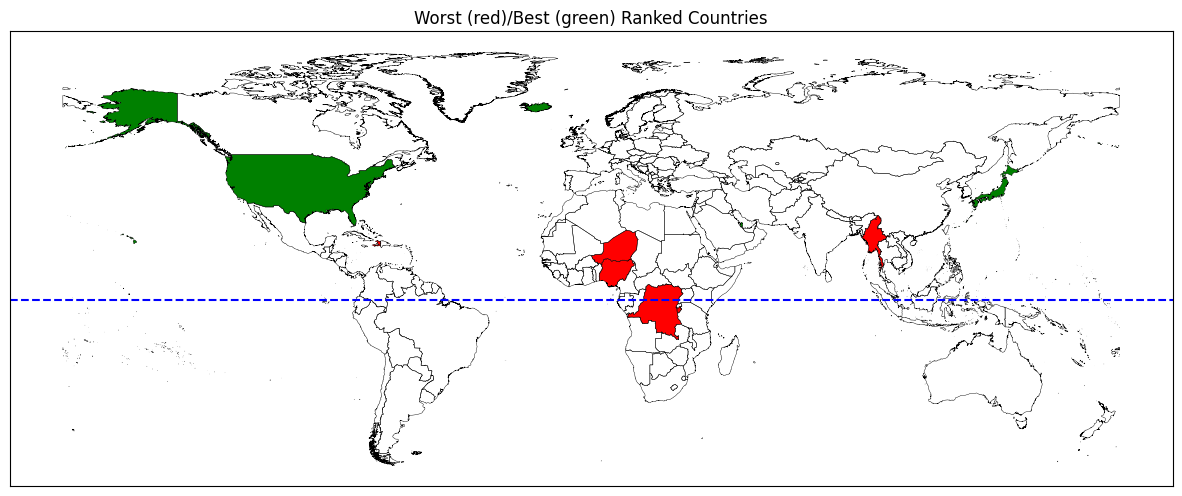

In [18]:
# Show worst/best ranked countries on world map

fig, ax = subplots(figsize=(15,15))

green_countries = ['Iceland', 'Singapore', 'United States of America', 'Qatar', 'Japan', 'Luxembourg']  # Seychelles is not on the list of countries in 'world_map', so can't plot; Qatar is in both lists but only presented once and is so small it won't be visible anyway
red_countries = ['Haiti', 'Myanmar', 'Dem. Rep. Congo', 'Nigeria', 'Niger', 'Burundi']

world_map.boundary.plot(linewidth=0.3, edgecolor='k', ax=ax)
ax.axhline(0, linestyle='--', c='b')
ax.set_title('Worst (red)/Best (green) Ranked Countries')
ax.set_xticks([])
ax.set_yticks([])
# ax.axis('off')
world_map[world_map['NAME'].isin(green_countries)].plot(color='g', ax=ax)
world_map[world_map['NAME'].isin(red_countries)].plot(color='r', ax=ax)

show()

<div class="alert alert-block alert-info">
<h4>Many of the 'worst' ranked countries are equatorial and in Africa (LMIC), whilst many of the 'best' ranked countries are in the northern hemisphere.<h4>

# Define X

In [19]:
X_df = countries_df.iloc[:, 1:]  # Exclude countries
print(X_df.shape)

X = X_df.to_numpy()  # Convert Pandas dataframe to NumPy array
X.shape

(167, 9)


(167, 9)

# Multivariate correlation analyses

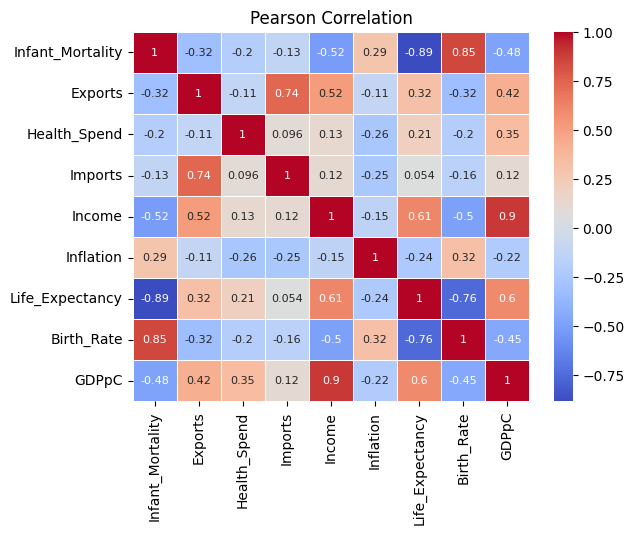

In [20]:
# Pandas Pearson Correlation

pc_mat = countries_df.corr(method='pearson', numeric_only=True)

fig, ax = subplots()

heatmap(pc_mat, annot=True, annot_kws={'fontsize':8}, linewidths=0.5, cmap='coolwarm')
ax.set_title('Pearson Correlation');

In [21]:
# NumPy Pearson Correlation Coefficient

cc_mat = corrcoef(X, rowvar=False)  # rowvar=False: correlation will be between columns/features not rows/samples

fill_diagonal(cc_mat, 0)  # Remove self-correlations (which are equal to 1) by setting them to 0

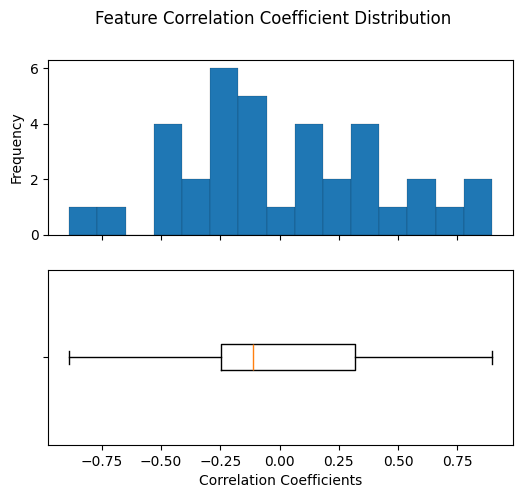

In [22]:
# Extract the correlation coefficients (only need the top right correlation coefficients of the matrix, since it is mirrored along the diagonal)
# and plot on a histogram/boxplot to visualise distribution.

n_rows = cc_mat.shape[0]  # Get the number of rows (or columns since it is a square matrix) of the correlation coefficient matrix
corr_coeff_ind = triu_indices(n_rows, k=1)  # Get the indices of the correlation coefficients; k=1 excludes the diagonal correlation coefficients
corr_coeffs = cc_mat[corr_coeff_ind]  # Return the ((9x9)-9)/2 = 36) correlation coefficents as a 1D array
# print(corr_coeffs.shape)

fig, ax = subplots(nrows=2, figsize=(6, 5))

n_bins = 15
line_width = 0.1
edge_colour = 'k'
ax[0].hist(corr_coeffs, bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[0].set_xticklabels([])
ax[0].set_ylabel('Frequency')

ax[1].boxplot(corr_coeffs, vert=False, tick_labels=[''])
ax[1].set_xlabel('Correlation Coefficients')

fig.suptitle('Feature Correlation Coefficient Distribution');


<div class="alert alert-block alert-info">
<h4>There are some strong correlations (< -0.75 & > 0.75).<h4>

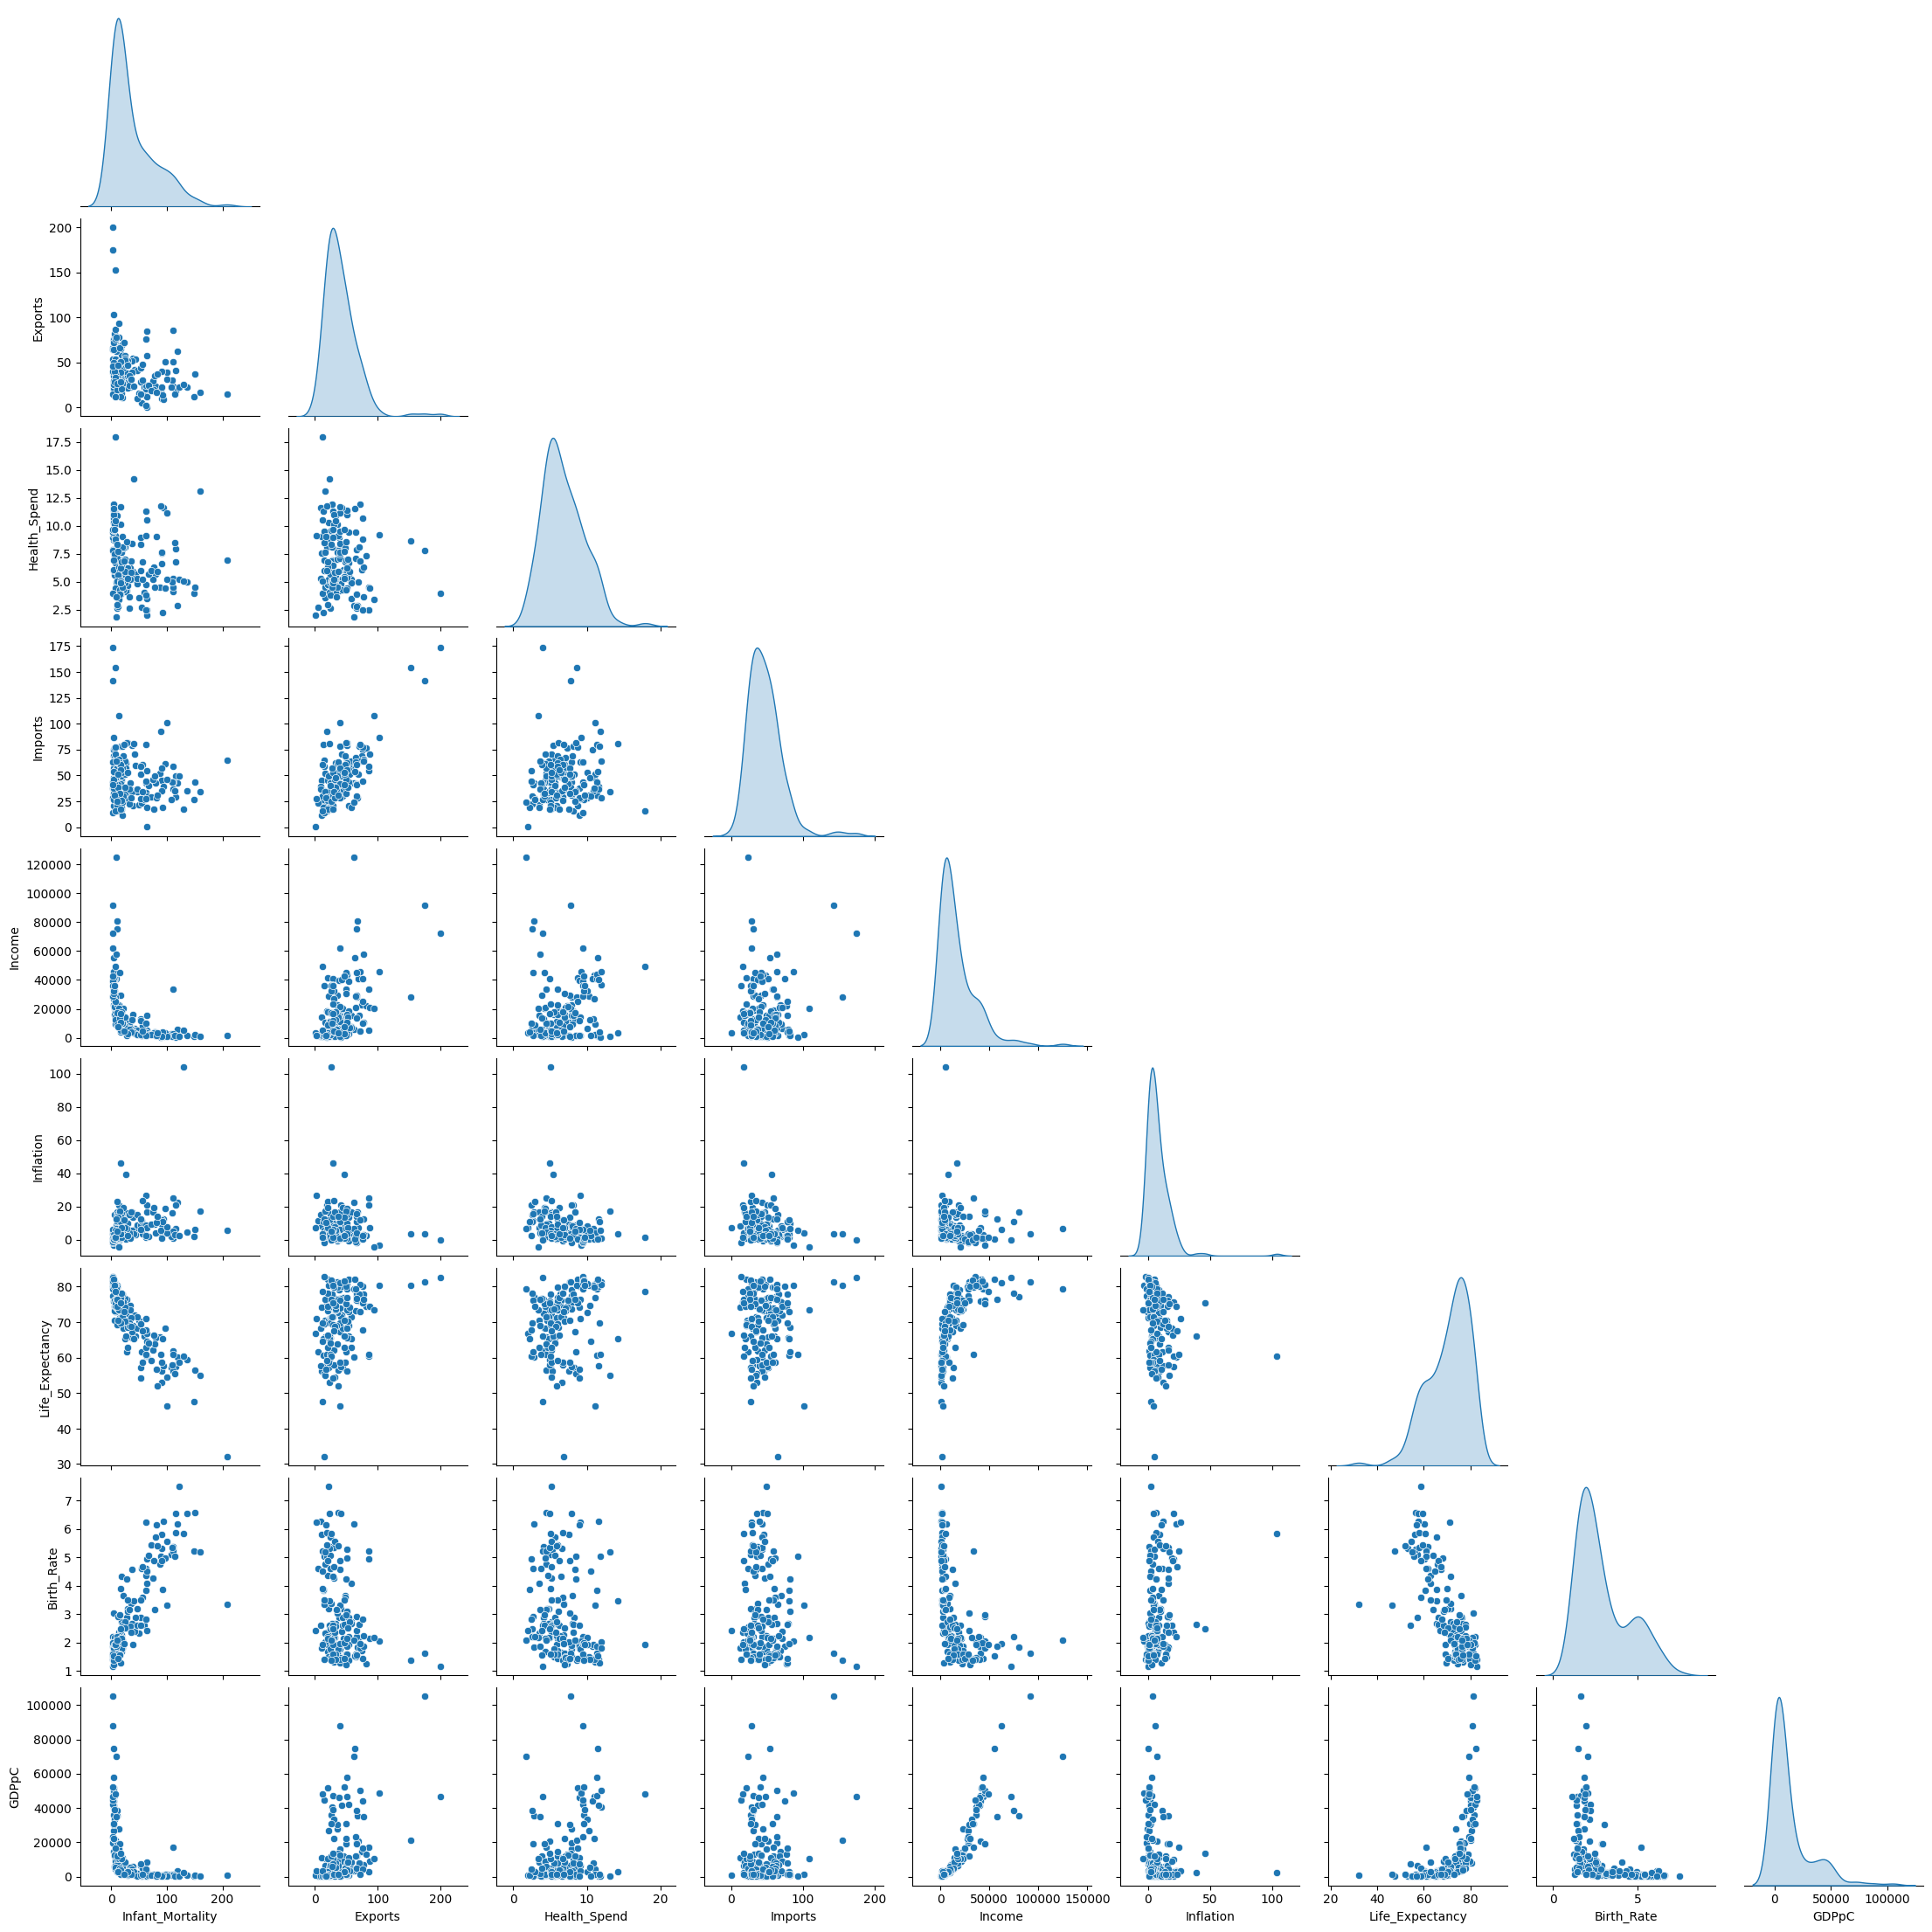

In [23]:
# Pairwise plot (Seaborn) of features

pairplot(countries_df, diag_kind='kde', corner=True);


<div class="alert alert-block alert-info">
From the above correlation plots:<br>
Unsurprisingly, infant mortality, life expectancy and birth rate show strong correlations, as do imports & exports.<br>
Income and life expectancy show moderate correlation.<br>
Surprisingly, health spending does not correlate strongly with GDP, income or life expectancy.<br>
Inflation correlates poorly with everything (drop?).

<div class="alert alert-block alert-info">
<h1>Prune dataset<h1>
<h3>Historically, low and middle income countries (LMIC) from Africa, South America and South Asia have been recipients of foreign financial aid.<br>

To aid clustering, it is a reasonable strategy to prune developed countries from the list based on some of the socio-economic and health data (*e.g.*, infant mortality < 5).<h3>

In [24]:
# Countries with 'low' infant mortality (< 5)

print(len(countries_df[countries_df['Infant_Mortality'] < 5.0]))  # Number of countries with 'low' infant mortallity (< 5)
countries_df[countries_df['Infant_Mortality'] < 5.0]

26


Country  Infant_Mortality  Exports  Health_Spend  Imports  Income  \
7         Australia               4.8     19.8          8.73     20.9   41400   
8           Austria               4.3     51.3         11.00     47.8   43200   
15          Belgium               4.5     76.4         10.70     74.7   41100   
42           Cyprus               3.6     50.2          5.97     57.5   33900   
43   Czech Republic               3.4     66.0          7.88     62.9   28300   
44          Denmark               4.1     50.5         11.40     43.6   44000   
51          Estonia               4.5     75.1          6.03     68.7   22700   
53          Finland               3.0     38.7          8.95     37.4   39800   
54           France               4.2     26.8         11.90     28.1   36900   
58          Germany               4.2     42.3         11.60     37.1   40400   
60           Greece               3.9     22.1         10.30     30.7   28700   
68          Iceland               2.6     53.4          9.40     43.3   38800   
73          Ireland               4.2    103.0          9.19     86.5   45700   
74           Israel               4.6     35.0          7.63     32.9   29600   
75            Italy               4.0     25.2          9.53     27.2   36200   
77            Japan               3.2     15.0          9.49     13.6   35800   
91       Luxembourg               2.8    175.0          7.77    142.0   91700   
110     Netherlands               4.5     72.0         11.90     63.6   45500   
114          Norway               3.2     39.7          9.48     28.5   62300   
122        Portugal               3.9     29.9         11.00     37.4   27200   
133       Singapore               2.8    200.0          3.96    174.0   72100   
135        Slovenia               3.2     64.3          9.41     62.9   28700   
138     South Korea               4.1     49.4          6.93     46.2   30400   
139           Spain               3.8     25.5          9.54     26.8   32500   
144          Sweden               3.0     46.2          9.63     40.7   42900   
145     Switzerland               4.5     64.0         11.50     53.3   55500   

     Inflation  Life_Expectancy  Birth_Rate   GDPpC  
7        1.160             82.0        1.93   51900  
8        0.873             80.5        1.44   46900  
15       1.880             80.0        1.86   44400  
42       2.010             79.9        1.42   30800  
43      -1.430             77.5        1.51   19800  
44       3.220             79.5        1.87   58000  
51       1.740             76.0        1.72   14600  
53       0.351             80.0        1.87   46200  
54       1.050             81.4        2.03   40600  
58       0.758             80.1        1.39   41800  
60       0.673             80.4        1.48   26900  
68       5.470             82.0        2.20   41900  
73      -3.220             80.4        2.05   48700  
74       1.770             81.4        3.03   30600  
75       0.319             81.7        1.46   35800  
77      -1.900             82.8        1.39   44500  
91       3.620             81.3        1.63  105000  
110      0.848             80.7        1.79   50300  
114      5.950             81.0        1.95   87800  
122      0.643             79.8        1.39   22500  
133     -0.046             82.7        1.15   46600  
135     -0.987             79.5        1.57   23400  
138      3.160             80.1        1.23   22100  
139      0.160             81.9        1.37   30700  
144      0.991             81.5        1.98   52100  
145      0.317             82.2        1.52   74600

<div class="alert alert-block alert-info">
<h4>These countries would be considered developed countries not urgently requiring foreign financial aid for infant health.<h4>

In [25]:
# Prune/remove countries with low infant mortality (< 5)

countries_df1 = countries_df[countries_df['Infant_Mortality'] > 5.0]  # NB: new dataframe with fewer countries

In [26]:
# Verify dropping 26 countries with infant mortality < 5 from 167

countries_df1.shape

(141, 10)

# Review univariate analysis after pruning

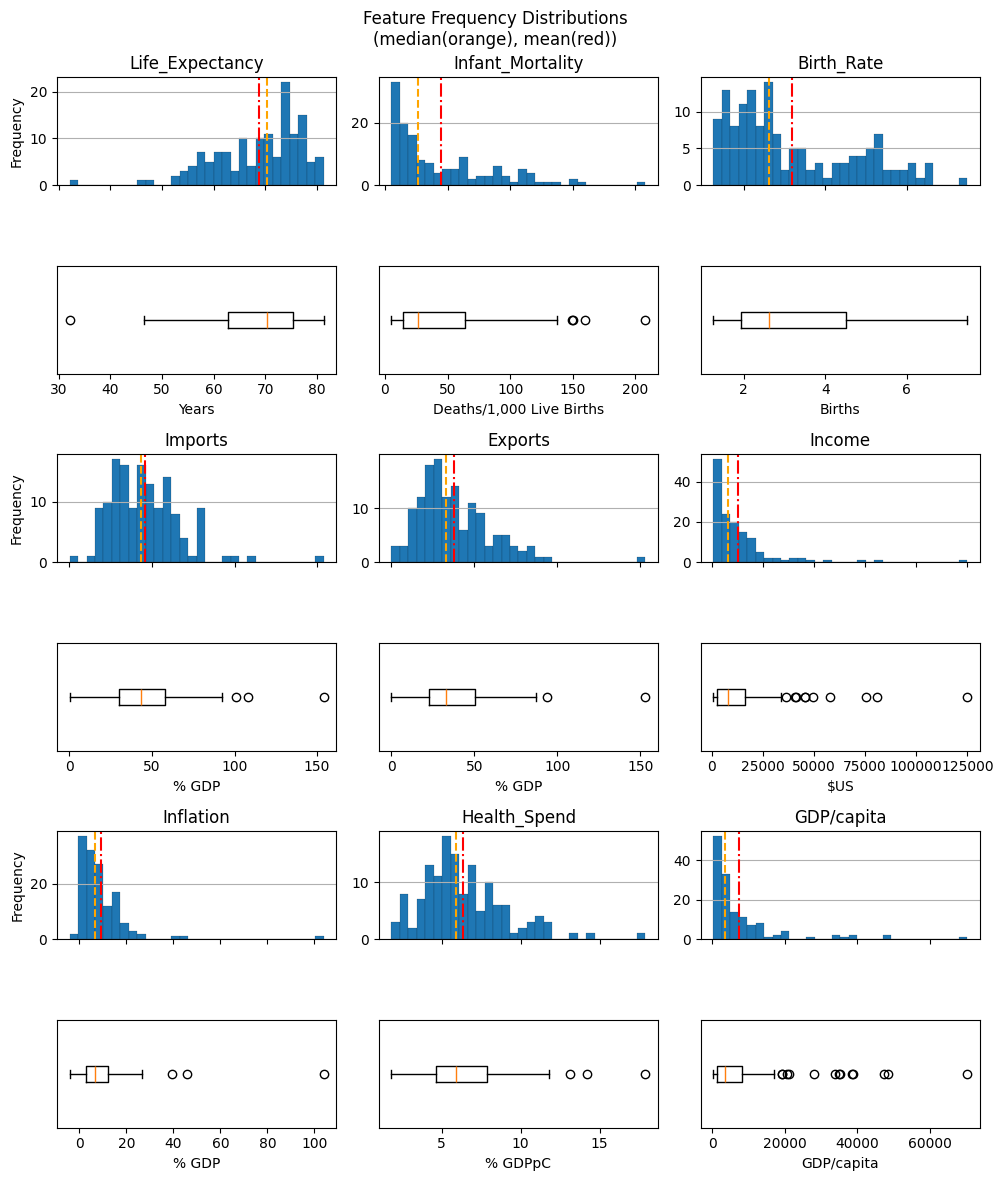

In [27]:
# Feature distribution

n_rows = 6
n_cols = 3
n_bins = 30
line_width = 0.1
edge_colour = 'k'

fig, ax  = subplots(nrows=n_rows, ncols=n_cols, figsize=(10,12))

ax[0,0].hist(countries_df1['Life_Expectancy'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[0,0].axvline(countries_df1['Life_Expectancy'].mean(), linestyle='-.', c='r')
ax[0,0].axvline(countries_df1['Life_Expectancy'].median(), linestyle='--', c='orange')
ax[0,0].grid(visible=True, axis='y')
# ax[0,0].set_xlabel('Years')
ax[0,0].set_xticklabels([])
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_title('Life_Expectancy')
ax[1,0].boxplot(countries_df1['Life_Expectancy'], vert=False)
ax[1,0].set_yticks([])
ax[1,0].set_xlabel('Years')

ax[0,1].hist(countries_df1['Infant_Mortality'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[0,1].axvline(countries_df1['Infant_Mortality'].mean(), linestyle='-.', c='r')
ax[0,1].axvline(countries_df1['Infant_Mortality'].median(), linestyle='--', c='orange')
# ax[0,1].set_xlabel('Deaths/1,000 Live Births')
ax[0,1].set_xticklabels([])
ax[0,1].grid(visible=True, axis='y')
ax[0,1].set_title('Infant_Mortality')
ax[1,1].boxplot(countries_df1['Infant_Mortality'], vert=False)
ax[1,1].set_yticks([])
ax[1,1].set_xlabel('Deaths/1,000 Live Births')

ax[0,2].hist(countries_df1['Birth_Rate'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[0,2].axvline(countries_df1['Birth_Rate'].mean(), linestyle='-.', c='r')
ax[0,2].axvline(countries_df1['Birth_Rate'].median(), linestyle='--', c='orange')
# ax[0,2].set_xlabel('Births')
ax[0,2].set_xticklabels([])
ax[0,2].grid(visible=True, axis='y')
ax[0,2].set_title('Birth_Rate')
ax[1,2].boxplot(countries_df1['Birth_Rate'], vert=False)
ax[1,2].set_yticks([])
ax[1,2].set_xlabel('Births')

ax[2,0].hist(countries_df1['Imports'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[2,0].axvline(countries_df1['Imports'].mean(), linestyle='-.', c='r')
ax[2,0].axvline(countries_df1['Imports'].median(), linestyle='--', c='orange')
ax[2,0].grid(visible=True, axis='y')
ax[2,0].set_xticklabels([])
# ax[2,0].set_xlabel('% GDP')
ax[2,0].set_ylabel('Frequency')
ax[2,0].set_title('Imports')
ax[3,0].boxplot(countries_df1['Imports'], vert=False)
ax[3,0].set_yticks([])
ax[3,0].set_xlabel('% GDP')

ax[2,1].hist(countries_df1['Exports'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[2,1].axvline(countries_df1['Exports'].mean(), linestyle='-.', c='r')
ax[2,1].axvline(countries_df1['Exports'].median(), linestyle='--', c='orange')
ax[2,1].grid(visible=True, axis='y')
ax[2,1].set_xticklabels([])
# ax[2,1].set_xlabel('% GDP')
ax[2,1].set_title('Exports')
ax[3,1].boxplot(countries_df1['Exports'], vert=False)
ax[3,1].set_yticks([])
ax[3,1].set_xlabel('% GDP')

ax[2,2].hist(countries_df1['Income'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[2,2].axvline(countries_df1['Income'].mean(), linestyle='-.', c='r')
ax[2,2].axvline(countries_df1['Income'].median(), linestyle='--', c='orange')
ax[2,2].grid(visible=True, axis='y')
ax[2,2].set_xticklabels([])
# ax[2,2].set_xlabel('$US')
ax[2,2].set_title('Income')
ax[3,2].boxplot(countries_df1['Income'], vert=False)
ax[3,2].set_yticks([])
ax[3,2].set_xlabel('$US')

ax[4,0].hist(countries_df1['Inflation'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[4,0].axvline(countries_df1['Inflation'].mean(), linestyle='-.', c='r')
ax[4,0].axvline(countries_df1['Inflation'].median(), linestyle='--', c='orange')
ax[4,0].grid(visible=True, axis='y')
ax[4,0].set_ylabel('Frequency')
ax[4,0].set_xticklabels([])
# ax[4,0].set_xlabel('% GDP')
ax[4,0].set_title('Inflation')
ax[5,0].boxplot(countries_df1['Inflation'], vert=False)
ax[5,0].set_yticks([])
ax[5,0].set_xlabel('% GDP')

ax[4,1].hist(countries_df1['Health_Spend'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[4,1].axvline(countries_df1['Health_Spend'].mean(), linestyle='-.', c='r')
ax[4,1].axvline(countries_df1['Health_Spend'].median(), linestyle='--', c='orange')
ax[4,1].grid(visible=True, axis='y')
ax[4,1].set_xticklabels([])
# ax[4,1].set_xlabel('% GDPpC')
ax[4,1].set_title('Health_Spend')
ax[5,1].boxplot(countries_df1['Health_Spend'], vert=False)
ax[5,1].set_yticks([])
ax[5,1].set_xlabel('% GDPpC')

ax[4,2].hist(countries_df1['GDPpC'], bins=n_bins, linewidth=line_width, edgecolor=edge_colour)
ax[4,2].axvline(countries_df1['GDPpC'].mean(), linestyle='-.', c='r')
ax[4,2].axvline(countries_df1['GDPpC'].median(), linestyle='--', c='orange')
ax[4,2].grid(visible=True, axis='y')
ax[4,2].set_xticklabels([])
# ax[4,2].set_xlabel('GDP/capita')
ax[4,2].set_title('GDP/capita')
ax[5,2].boxplot(countries_df1['GDPpC'], vert=False)
ax[5,2].set_yticks([])
ax[5,2].set_xlabel('GDP/capita')

fig.suptitle('Feature Frequency Distributions\n(median(orange), mean(red))')
fig.tight_layout()

# Review multivariate correlation analyses after pruning

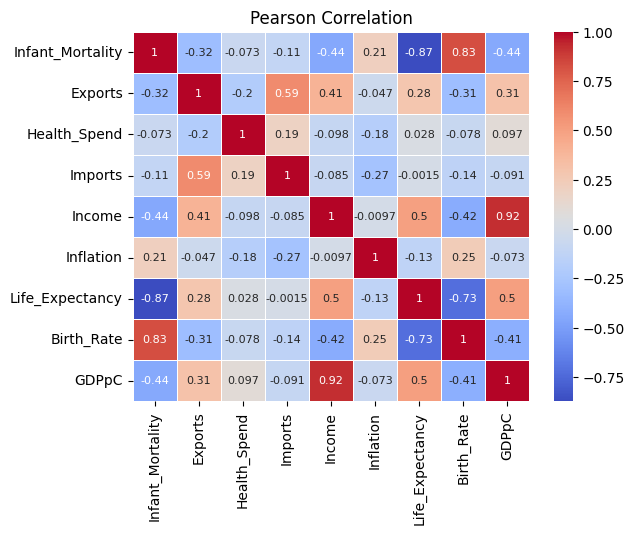

In [28]:
# Pandas Pearson Correlation

pc_mat = countries_df1.corr(method='pearson', numeric_only=True)

fig, ax = subplots()

heatmap(pc_mat, annot=True, annot_kws={'fontsize':8}, linewidths=0.5, cmap='coolwarm')
ax.set_title('Pearson Correlation');

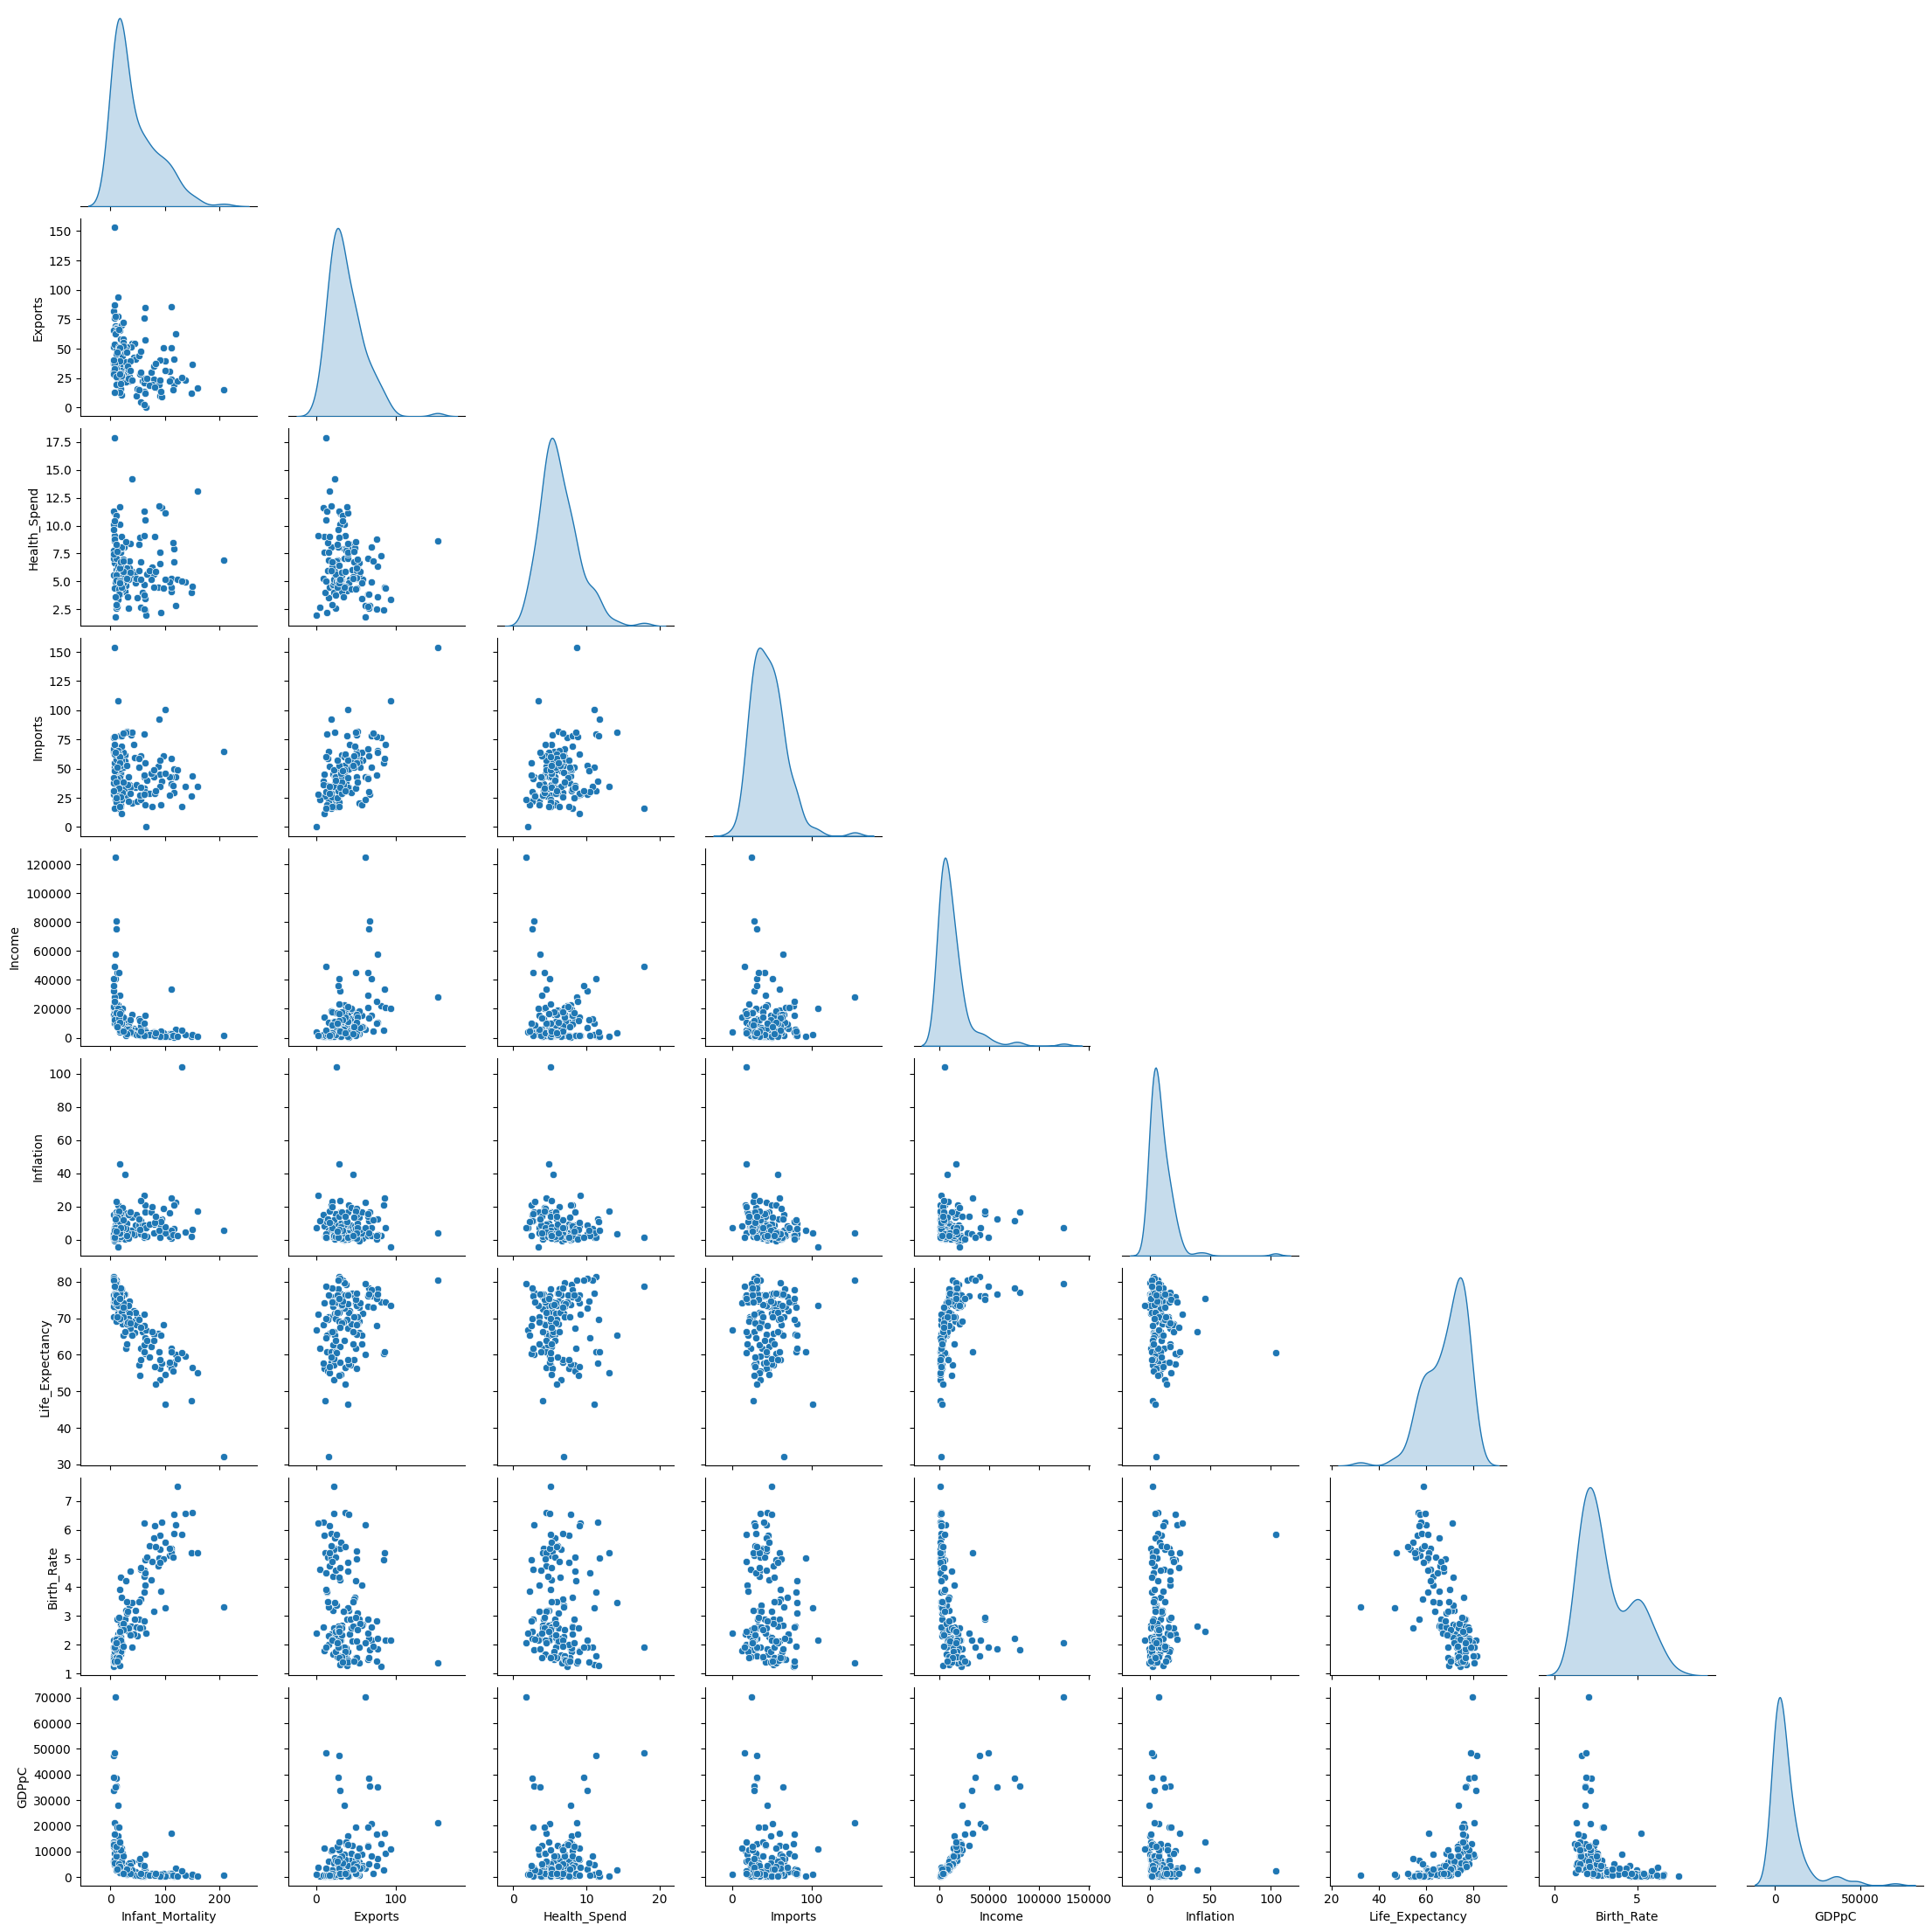

In [29]:
# Pairwise plot (Seaborn) of features

pairplot(countries_df1, diag_kind='kde', corner=True);


<div class="alert alert-block alert-info">
<h4>Interestingly, it is not necessarily the case that countries with high GDPpC spend proportionally more on health - but their infant mortality is lower and life expectancy is higher, so there are contributing factors other than health spending (<i>e.g.</i>, infrastructure for clean water, housing, accessibility to hospitals and trained healthcare professionals, <i>etc</i>) unaccounted for in this dataset that confound analyses.<br>

Birth rate is inversely proportional to life expectancy regardless of wealth (GDP & income). This is interesting and suggests a human instinct to survive against attrition.<h4>

# Feature engineering

In [30]:
# Create new dataframe for feature engineering/dropping

countries_df2 = countries_df1.copy()
countries_df2.shape

(141, 10)

In [31]:
# Trade Deficit = Exports - Imports

countries_df2['Trade_Def'] = countries_df2['Exports'] - countries_df2['Imports']

# Drop 'Exports' & 'Imports'
countries_df2.drop(['Exports', 'Imports'], axis=1, inplace=True)

# Verify addition of new feature (Trade_Def) and dropped features (Exports & Imports)
print(countries_df2.shape)
countries_df2.columns

(141, 9)


Index(['Country', 'Infant_Mortality', 'Health_Spend', 'Income', 'Inflation',
       'Life_Expectancy', 'Birth_Rate', 'GDPpC', 'Trade_Def'],
      dtype='object')

In [32]:
# LE/IM = Life Expectancy/Infant Mortality

countries_df2['LE/IM'] = countries_df2['Life_Expectancy'] / countries_df2['Infant_Mortality']

# Drop 'Life_Expectancy' & 'Infant_Mortality'
countries_df2.drop(['Life_Expectancy', 'Infant_Mortality'], axis=1, inplace=True)

# Verify addition of new feature (LE/IM) and dropped features (Life_Expectancy & Infant_Mortality)
print(countries_df2.shape)
countries_df2.columns

(141, 8)


Index(['Country', 'Health_Spend', 'Income', 'Inflation', 'Birth_Rate', 'GDPpC',
       'Trade_Def', 'LE/IM'],
      dtype='object')

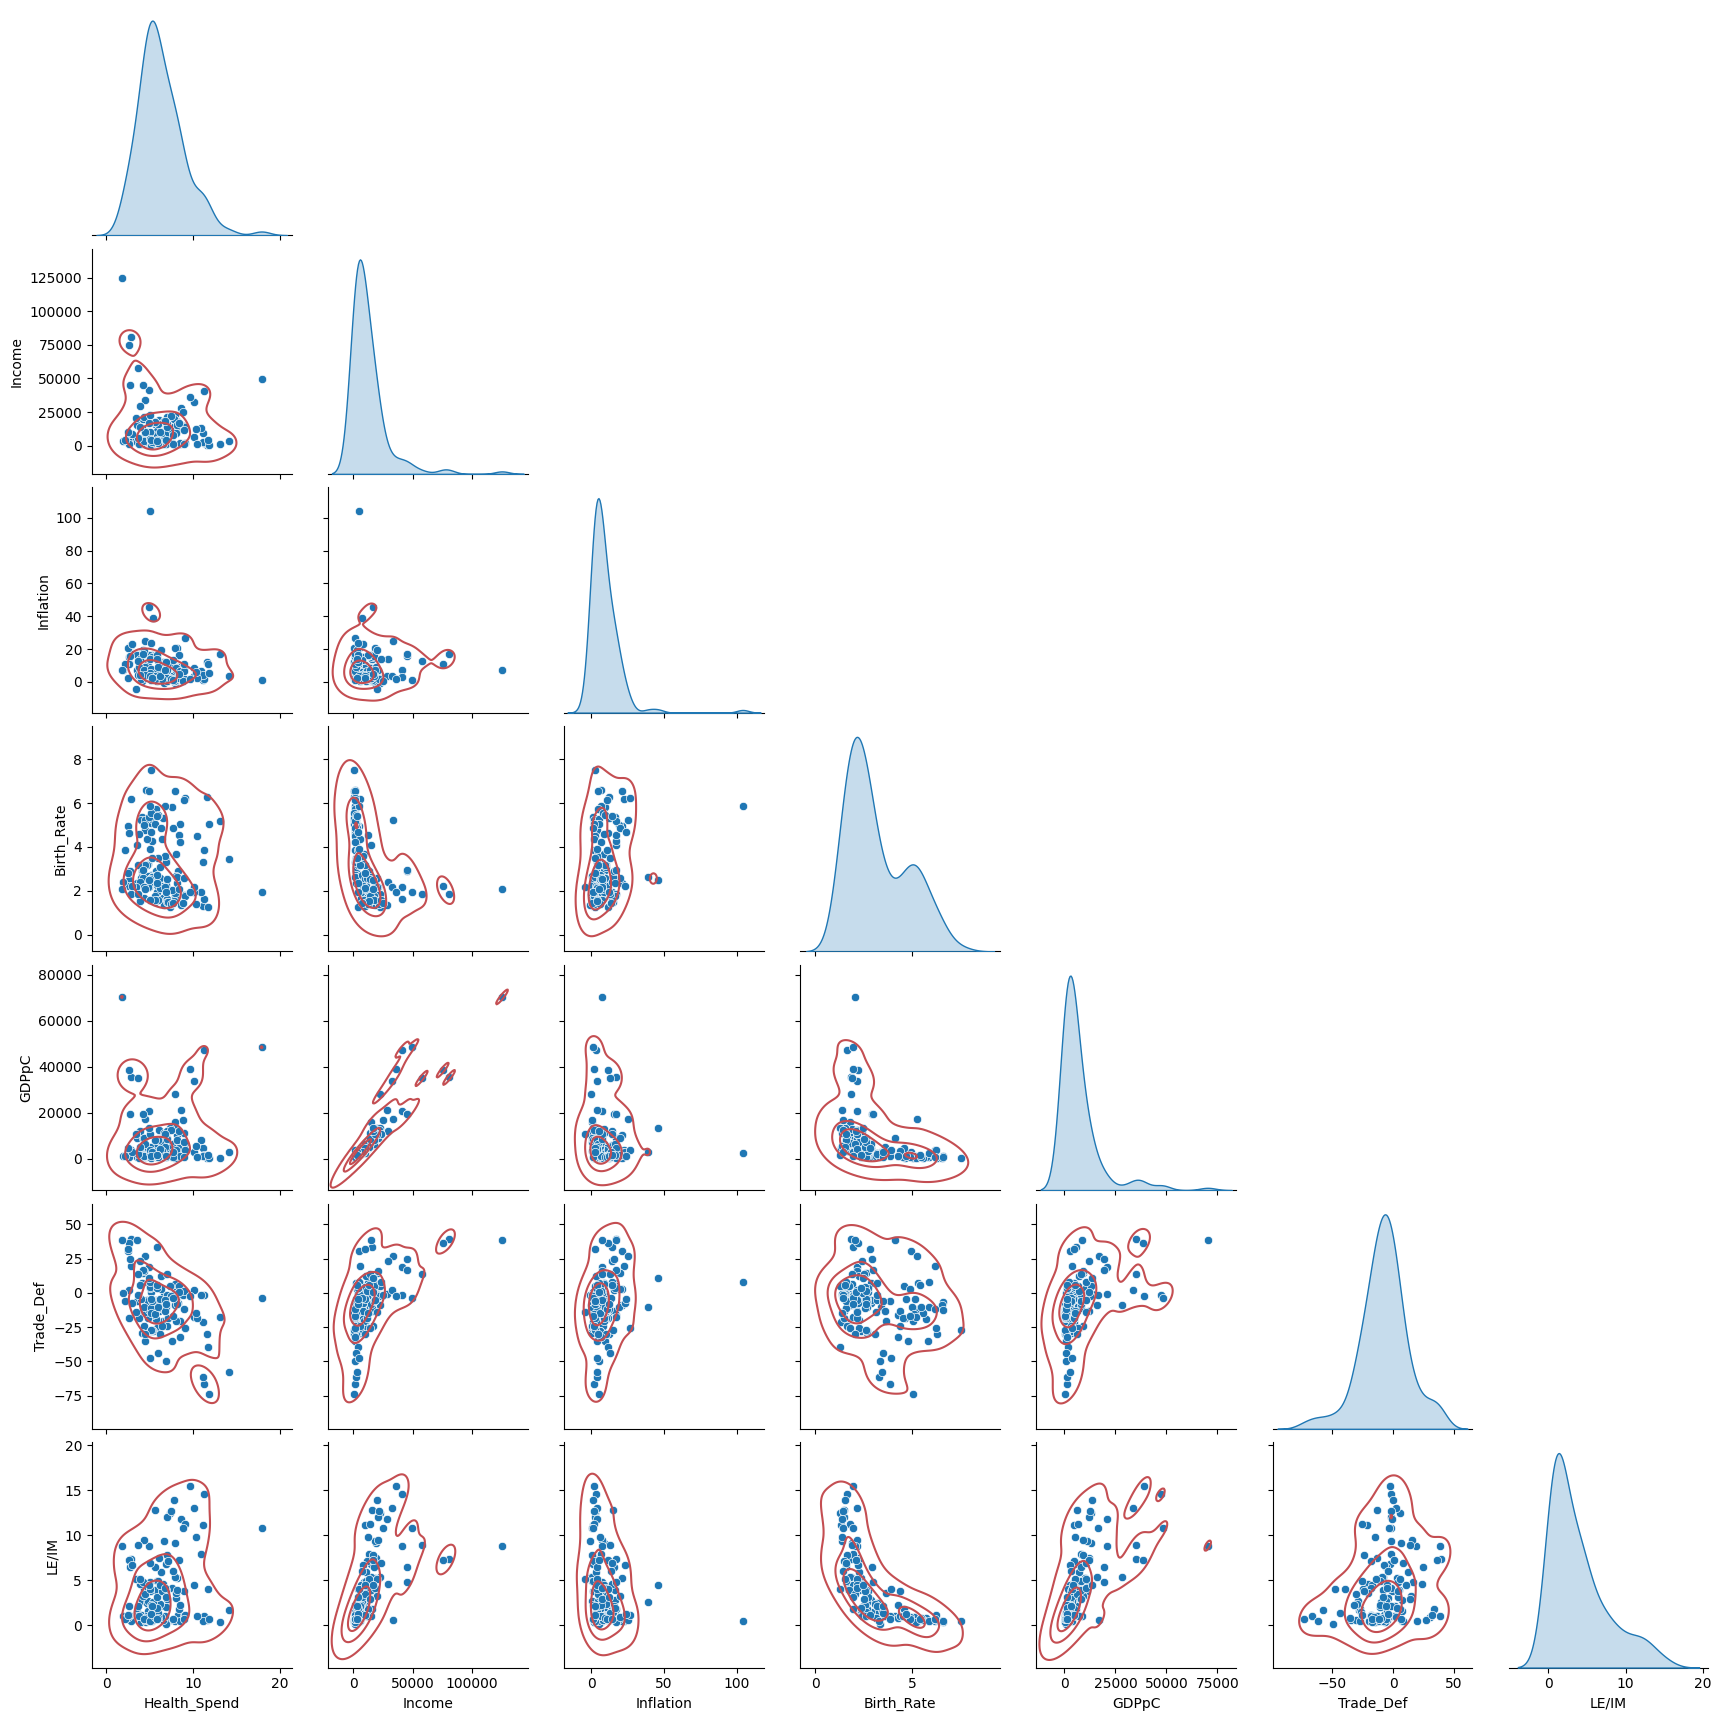

In [33]:
# Pairwise plot (Seaborn) of features

pp = pairplot(countries_df2, diag_kind='kde', corner=True)
pp.map_lower(kdeplot, levels=4, color='#C44E52');  # Contour level and colour


<div class="alert alert-block alert-info">
<h4>Birth rate and GDPpC show distinct clusters separated at 4 and ~20,000, respectively.<h4>

In [34]:
# Higher birth rates are associated with lower life expectancies
# Inspect birth rates less than/greater than 4

# countries_df2.groupby(countries_df2['Birth_Rate'] < 4).describe()
countries_df2.groupby(countries_df2['Birth_Rate'] < 4).mean(numeric_only=True)

Health_Spend        Income  Inflation  Birth_Rate        GDPpC  \
Birth_Rate                                                                   
False           6.226341   3532.756098  12.765976    5.302927  1726.097561   
True            6.421200  16430.200000   7.467810    2.306600  9557.440000   

            Trade_Def     LE/IM  
Birth_Rate                       
False      -11.172927  0.830109  
True        -6.358769  5.157229

<div class="alert alert-block alert-info">
There are 100 countries where birth rate < 4 (True). Apart from similar health spending, their feature means are more favourable than the 41 countries with birth rate > 4 (False).<br>

The engineered features (Trade_Def & LE/IM) also exhibit significant differences.

In [35]:
# Inspect GDPpC around 20,000

# countries_df2.groupby(countries_df2['GDPpC'] < 20_000).describe()
countries_df2.groupby(countries_df2['GDPpC'] < 20_000).mean(numeric_only=True)

Health_Spend        Income  Inflation  Birth_Rate         GDPpC  \
GDPpC                                                                    
False      7.399091  53572.727273   6.149727    1.910909  37936.363636   
True       6.277000   9219.715385   9.250300    3.285077   4686.261538   

       Trade_Def      LE/IM  
GDPpC                        
False  11.963636  10.190501  
True   -9.427438   3.366630

<div class="alert alert-block alert-info">
There are 130 countries with GDP/capita < $US20,000 (True). Their feature means are less favourable than the 11 countries with GDP/capita > $US20,000 (False).<br>

The engineered features (Trade_Def & LE/IM) also exhibit significant differences.

<div class="alert alert-block alert-info">
<h3>Birth rate and GDP appear to be good indicators for infant health, and therefore, foreign financial aid.<h3>

### Compare KMeans clustering of GDP & Birth Rate (X_2) and KMeans clustering of all features (X_all)<br>

# Define new Xs (X_2 & X_all)

In [36]:
# Only birth rate & GDP/capita

X_2_df = countries_df2.iloc[:, 4:6]  # Only include 'Birth_Rate' & 'GDPpC'
print(X_2_df.shape)
print(X_2_df.columns)

X_2 = X_2_df.to_numpy()
print(X_2.shape)

(141, 2)
Index(['Birth_Rate', 'GDPpC'], dtype='object')
(141, 2)


In [37]:
# All features

X_all_df = countries_df2.iloc[:, 1:]  # Exclude countries
print(X_all_df.shape)
print(X_all_df.columns)

X_all = X_all_df.to_numpy()  # Convert Pandas dataframe to NumPy array
X_all.shape

(141, 7)
Index(['Health_Spend', 'Income', 'Inflation', 'Birth_Rate', 'GDPpC',
       'Trade_Def', 'LE/IM'],
      dtype='object')


(141, 7)

# Scale

In [38]:
# Normaliser

norm_scl = Normalizer()

X_all_norm_scaled = norm_scl.fit_transform(X_all)

X_2_norm_scaled = norm_scl.fit_transform(X_2)

In [39]:
# Robust scaler

rob_scl = RobustScaler()

X_all_rob_scaled = rob_scl.fit_transform(X_all)

X_2_rob_scaled = rob_scl.fit_transform(X_2)

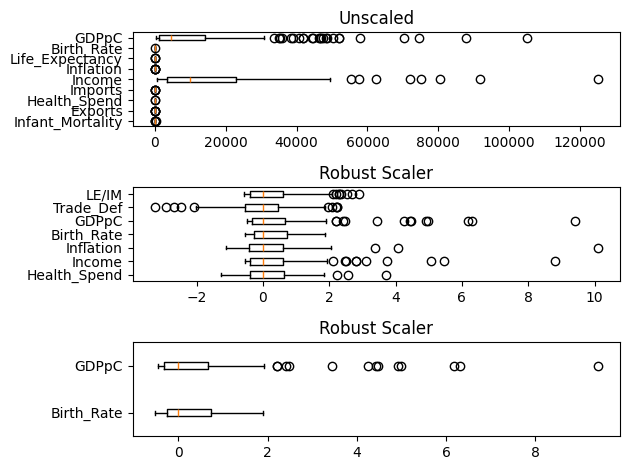

In [40]:
# Inspect scaling effect

n_rows = 3
n_cols = 1
y_labels = X_df.columns
y_all_labels = X_all_df.columns
y_2_labels = X_2_df.columns

fig, ax = subplots(nrows=n_rows, ncols=n_cols)

ax[0].boxplot(X, vert=False)
ax[0].set_yticklabels(y_labels)
ax[0].set_title('Unscaled')

ax[1].boxplot(X_all_rob_scaled, vert=False)
ax[1].set_yticklabels(y_all_labels)
ax[1].set_title('Robust Scaler')

ax[2].boxplot(X_2_rob_scaled, vert=False)
ax[2].set_yticklabels(y_2_labels)
ax[2].set_title('Robust Scaler')

fig.tight_layout()


# PCA

In [41]:
# Scree plot
def scree_plot(exp_var, cum_exp_var, title=""):
    """
    Given the explained variances/Eigenvalues of a PCA, plots a scree plot 
    :param exp_var: PCA explained variance
    :type exp_var: NumPy array
    :param cum_exp_var: cumulative explained variance
    :type cum_exp_var: NumPy array
    :param title: str (optional)
    :rtype: matplotlib bar graph
    """
    # plt_labels = ['PC' + str(x) for x in range(1, len(exp_var)+1)]
    plt_labels = [str(x) for x in range(1, len(exp_var)+1)]

    fig, ax = subplots()

    bar_con = ax.bar(x=range(1, len(exp_var)+1), height=exp_var, tick_label=plt_labels)
    ax.bar_label(bar_con, fontsize=7)  # .bar_label() uses the the data values (i.e., height=exp_var) from the container (bar_con) as labels
    ax.plot(range(1, len(exp_var)+1), cum_exp_var, 'r--', marker='o')
    ax.set_ylabel(f'% Explained Variance')
    ax.set_xlabel('Principal Components')
    ax.set_title(f"{title} Scree Plot")


# PC number
def numPC(exp_var, cum_exp_var, cutoff=99.0):
    """
    Returns the number of Principal Components needed to reach a desired threshold/cutoff of cumulative explained variances
    :param exp_var: Explained Variance/Eigenvalues
    :type exp_var: NumPy array
    :param cum_exp_var: Cumulative sum of explained variances/eigenvalues
    :type cum_exp_var: NumPy array
    :param cutoff: Desired value of cumulative sum of explained variances/eigenvalues (optional)
    :type cutoff: int, float (0-100%), default=99.0
    """
    num_pc = [i for i in range(len(exp_var)) if cum_exp_var[i] >= cutoff][0] + 1  # Returns the index of cumulative PC Eigenvalues that meets the cutoff
    print(f"The number of PCs to attain {cutoff}% explained variance = {num_pc}.")
    return num_pc

PCA centers but does not scale the input data for each feature before applying the SVD. The optional parameter `whiten=True` makes it possible to project the data onto the singular space while scaling each component to unit variance. This is often useful if the models down-stream make strong assumptions on the isotropy of the signal: this is for example the case for Support Vector Machines with the RBF kernel and the K-Means clustering algorithm.<br>
https://scikit-learn.org/stable/modules/decomposition.html

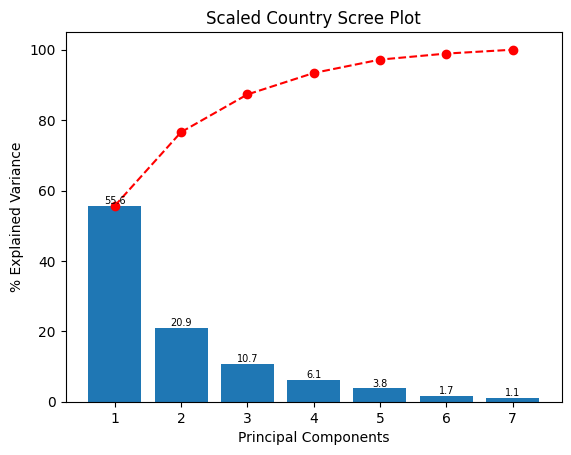

In [42]:
# PCA of scaled data

RS = 962  # Random state

pca = PCA(whiten=True, random_state=RS)

X_all_pca = pca.fit_transform(X_all_rob_scaled)

evr = round(pca.explained_variance_ratio_ * 100, 1)  # Obtain the principal component values (eigenvalues)
# print(evr)

cum_evr = cumsum(pca.explained_variance_ratio_ * 100)  # Cumulative summation of explained variances/eigenvalues
# print(cum_evr)

scree_plot(evr, cum_evr, 'Scaled Country')

In [43]:
print(X_all_pca.shape)
X_all_pca

(141, 7)


array([[-8.96151365e-01, -2.74333214e-01,  7.17330708e-01,
        -1.40036447e+00, -2.30454902e-01,  8.10186677e-01,
         8.97423353e-01],
       [-2.16676335e-01, -5.93588572e-01, -2.60493908e-02,
         5.10409358e-01, -8.95018177e-01, -8.85382239e-01,
        -1.23703300e-01],
       [-7.94501935e-02,  9.30146659e-01, -5.04797565e-01,
         4.40069463e-01, -7.81704115e-02, -4.12049059e-01,
        -6.42830105e-02],
       [-3.67045489e-01,  1.84261621e+00, -7.10258366e-01,
        -4.46480981e-01,  1.05501437e+00,  1.80229803e+00,
        -7.28121125e-02],
       [ 4.90029773e-01, -7.36373547e-01, -2.03205686e-01,
         3.44261493e-01, -8.28632721e-01,  5.33540407e-01,
         5.77999619e-02],
       [ 3.77423501e-01,  7.16073524e-01,  9.95835212e-01,
         7.16908877e-01,  4.73732662e-01, -7.81987161e-01,
         1.60679658e-01],
       [-3.74043820e-01, -2.48604172e-01, -2.27319290e-01,
         4.41028991e-01, -1.84376294e+00, -3.53271067e-01,
        -8.7525902

In [44]:
# Number of PCs needed to attain cummulative explained variance of a specified cutoff

num_pc = numPC(evr, cum_evr, cutoff=95.0)

The number of PCs to attain 95.0% explained variance = 5.


In [45]:
# Apply num_pc

pca = PCA(n_components=num_pc, whiten=True, random_state=RS)

X_pca = pca.fit_transform(X_all_norm_scaled)
print(X_pca.shape)
X_pca

(141, 5)


array([[-9.30946080e-01, -8.03046837e-01, -1.35347456e+00,
        -1.16845982e-02, -3.04893091e-01],
       [-5.04082025e-01,  3.91393169e-02,  3.23738823e-01,
        -5.14084155e-01, -2.37323055e-01],
       [-9.15714050e-01, -6.33543423e-01,  6.79705578e-01,
        -3.93644092e-01, -2.88778555e-01],
       [ 5.68462091e-01,  9.00012812e-01,  4.72596017e-01,
         8.50103549e-01, -2.39857890e-01],
       [ 7.80878172e-01,  9.05214190e-01,  1.93698420e-01,
        -1.72356062e-01, -1.61568094e-01],
       [ 3.09235549e-01,  8.11086651e-01,  3.08478350e-01,
         7.07502654e-03, -3.09988782e-01],
       [-9.22202851e-02,  5.12155968e-01,  7.84963724e-02,
        -2.71560791e-01, -6.07351573e-01],
       [-7.94380938e-01, -4.02650314e-01,  7.70139211e-01,
        -3.46896436e-01, -9.62723842e-03],
       [ 3.04141523e+00, -2.22490663e+00,  4.48585314e-01,
        -3.07929923e-01,  2.65261744e-01],
       [ 4.20770201e-02,  6.49079753e-01,  4.00482784e-01,
        -2.84701916e-01

#### Won't proceed with PCA analysis due to time constraints.

# KMeans clustering - No PCA

In [46]:
# Calculate optimal cluster number for KMeans
def km_cluster_opt(data, max_k=10):
    """
    Calculates & plots the inertias (elbow plot) for user specified cluster number (max_k=10, default).
    Also plots the inertia deltas between clusters to help determine optimal k.
    Returns two plots for user to determine the optimal number of clusters for KMeans

    :param data: Data for KMeans clustering
    :type data: NumPy array
    :rtype: Matplotlib plot
    :rtype: Lists of inertias & inertia deltas (optional)
    """
    clusters = []  # List of clusters
    inertias = []  # List of inertias

    for k in range(1, max_k+1):
        km = KMeans(n_clusters=k)
        km.fit(data)

        clusters.append(k)
        inertias.append(km.inertia_)
    
    _, ax = subplots()  # Underscore variable '_' indicates unused unpacking variable
    ax.plot(clusters, inertias, 'o-')
    ax.set_title(f'Inertia Minimisation for {max_k} Clusters')
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Inertia')
    ax.grid(True)

    # To help visualise the change in inertias
    # Calculate the inertia deltas, i.e., the change in inertia between successive clusters, i.e., inertia(i) - inertia(i+1), where i = number of clusters
    inertias_deltas = []
    for i in range(max_k-1):
        delta = inertias[i] - inertias[i+1]
        inertias_deltas.append(delta)

    # Plot inertia deltas
    _, ax = subplots()

    xtick_labels = [f"{i}-{i+1}" for i in range(1,len(inertias_deltas)+1)]  # List comprehension to make x-tick labels
    ax.bar(x=range(1,max_k,1), height=inertias_deltas)
    ax.set_xticks(range(1,max_k,1), labels=xtick_labels)
    ax.set_xlabel('Clusters')
    ax.set_ylabel('Inertia Delta')
    ax.set_title('Change in Inertia Between Clusters');

    # return inertias, inertias_deltas

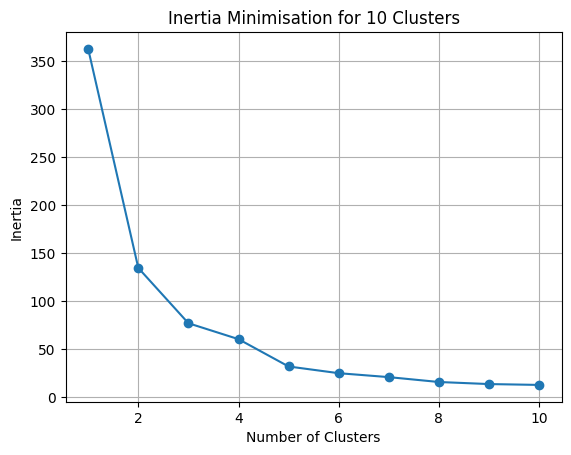

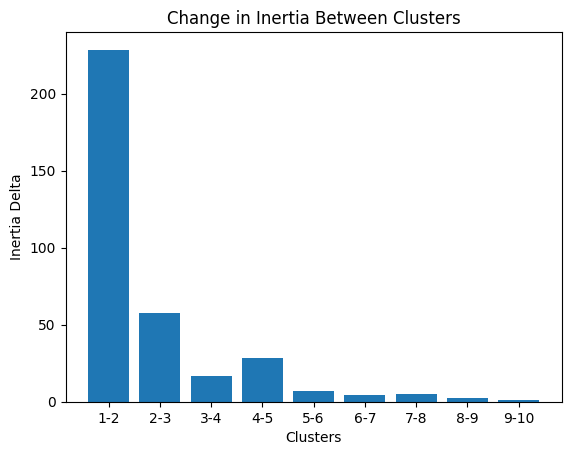

In [47]:
# Inertia elbow plot for X_2

km_cluster_opt(X_2_rob_scaled)

Optimal k = 2, for X_2

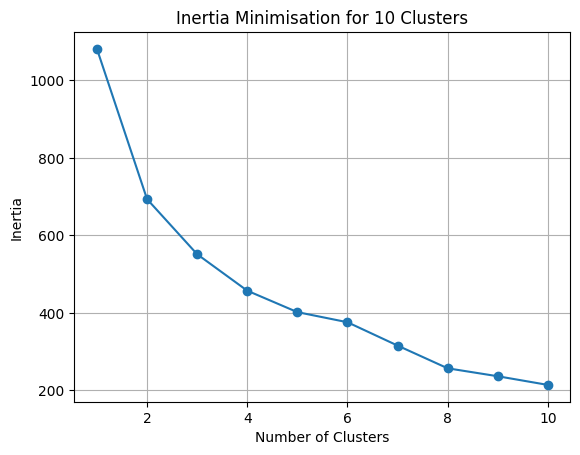

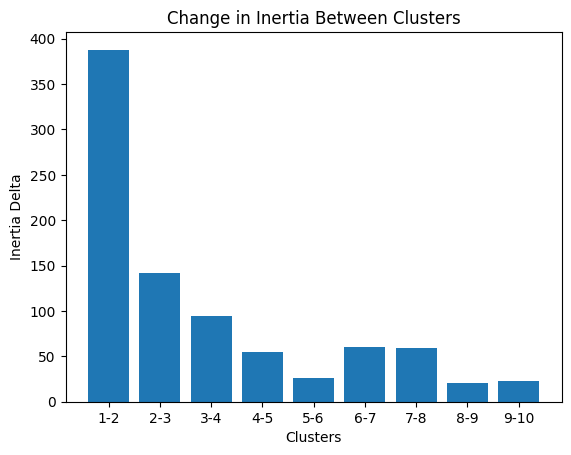

In [48]:
# Inertia elbow plot for X_all

km_cluster_opt(X_all_rob_scaled)

Optimal k = 2, for X_all

<div class="alert alert-block alert-info">
<h3>Regardless of the elbow method, in the context of this project's objective, using 2 clusters (financial aid/no financial aid) or 3 clusters (priority financial aid/alternate financial aid/no financial aid) would be appropriate.<br>

Let k = 3.<h3>

# KMeans for X_2

In [49]:
k = 3
km = KMeans(n_clusters=k, random_state=RS)

cluster_pred_2 = km.fit_predict(X_2_rob_scaled)  # Predict the 3 clusters for X_2
print(cluster_pred_2)

[0 2 0 0 2 2 2 2 1 2 0 2 2 0 0 0 0 2 2 2 1 2 0 0 0 0 1 0 0 0 2 2 2 0 0 0 2
 0 2 2 0 0 0 2 0 0 2 0 0 0 2 0 0 0 0 0 2 0 0 2 0 2 0 2 0 0 1 0 0 2 2 0 0 2
 2 2 0 0 2 2 0 2 0 2 0 0 0 2 0 0 0 0 0 1 0 0 2 0 2 0 2 0 2 1 2 2 0 0 2 0 2
 2 0 2 0 2 0 2 0 2 0 0 2 0 0 0 2 2 0 0 2 1 1 1 2 0 0 2 0 0 0]


In [50]:
# Add predicted clusters to 'countries_df1' which has all the original features

countries_df1['3Cluster'] = cluster_pred_2
print(len(countries_df1))
countries_df1

141


/var/folders/8c/bf334cs149s9dwx169yz6k700000gn/T/ipykernel_87150/3994080293.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countries_df1['3Cluster'] = cluster_pred_2


Country  Infant_Mortality  Exports  Health_Spend  Imports  \
0            Afghanistan              90.2     10.0          7.58     44.9   
1                Albania              16.6     28.0          6.55     48.6   
2                Algeria              27.3     38.4          4.17     31.4   
3                 Angola             119.0     62.3          2.85     42.9   
4    Antigua and Barbuda              10.3     45.5          6.03     58.9   
..                   ...               ...      ...           ...      ...   
162              Vanuatu              29.2     46.6          5.25     52.7   
163            Venezuela              17.1     28.5          4.91     17.6   
164              Vietnam              23.3     72.0          6.84     80.2   
165                Yemen              56.3     30.0          5.18     34.4   
166               Zambia              83.1     37.0          5.89     30.9   

     Income  Inflation  Life_Expectancy  Birth_Rate  GDPpC  3Cluster  
0      1610       9.44             56.2        5.82    553         0  
1      9930       4.49             76.3        1.65   4090         2  
2     12900      16.10             76.5        2.89   4460         0  
3      5900      22.40             60.1        6.16   3530         0  
4     19100       1.44             76.8        2.13  12200         2  
..      ...        ...              ...         ...    ...       ...  
162    2950       2.62             63.0        3.50   2970         0  
163   16500      45.90             75.4        2.47  13500         2  
164    4490      12.10             73.1        1.95   1310         0  
165    4480      23.60             67.5        4.67   1310         0  
166    3280      14.00             52.0        5.40   1460         0  

[141 rows x 11 columns]

In [51]:
# '0' cluster countries

countries_df1[countries_df1['3Cluster'] == 0]

Country  Infant_Mortality  Exports  Health_Spend  Imports  Income  \
0    Afghanistan              90.2     10.0          7.58     44.9    1610   
2        Algeria              27.3     38.4          4.17     31.4   12900   
3         Angola             119.0     62.3          2.85     42.9    5900   
12    Bangladesh              49.4     16.0          3.52     21.8    2440   
16        Belize              18.8     58.2          5.20     57.5    7880   
..           ...               ...      ...           ...      ...     ...   
161   Uzbekistan              36.3     31.7          5.81     28.5    4240   
162      Vanuatu              29.2     46.6          5.25     52.7    2950   
164      Vietnam              23.3     72.0          6.84     80.2    4490   
165        Yemen              56.3     30.0          5.18     34.4    4480   
166       Zambia              83.1     37.0          5.89     30.9    3280   

     Inflation  Life_Expectancy  Birth_Rate  GDPpC  3Cluster  
0         9.44             56.2        5.82    553         0  
2        16.10             76.5        2.89   4460         0  
3        22.40             60.1        6.16   3530         0  
12        7.14             70.4        2.33    758         0  
16        1.14             71.4        2.71   4340         0  
..         ...              ...         ...    ...       ...  
161      16.50             68.8        2.34   1380         0  
162       2.62             63.0        3.50   2970         0  
164      12.10             73.1        1.95   1310         0  
165      23.60             67.5        4.67   1310         0  
166      14.00             52.0        5.40   1460         0  

[78 rows x 11 columns]

In [52]:
cluster0_countries = countries_df1['Country'][countries_df1['3Cluster'] == 0].values
print(len(cluster0_countries))
cluster0_countries

78


array(['Afghanistan', 'Algeria', 'Angola', 'Bangladesh', 'Belize',
       'Benin', 'Bhutan', 'Bolivia', 'Burkina Faso', 'Burundi',
       'Cambodia', 'Cameroon', 'Cape Verde', 'Central African Republic',
       'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.',
       "Cote d'Ivoire", 'Ecuador', 'Egypt', 'El Salvador', 'Eritrea',
       'Fiji', 'Gambia', 'Georgia', 'Ghana', 'Guatemala', 'Guinea',
       'Guinea-Bissau', 'Guyana', 'Haiti', 'India', 'Indonesia', 'Iraq',
       'Jordan', 'Kenya', 'Kiribati', 'Kyrgyz Republic', 'Lao', 'Lesotho',
       'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania',
       'Micronesia, Fed. Sts.', 'Moldova', 'Mongolia', 'Morocco',
       'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Niger', 'Nigeria',
       'Pakistan', 'Paraguay', 'Philippines', 'Rwanda', 'Samoa',
       'Senegal', 'Sierra Leone', 'Solomon Islands', 'Sri Lanka', 'Sudan',
       'Tajikistan', 'Tanzania', 'Timor-Leste', 'Togo', 'Tonga',
       'Turkmenistan', 'Uganda', 'Uzbekist

In [53]:
# Change some country names to be consistent with geopandas (for mapping)

countries_df1.loc[countries_df1['Country'] == "Cote d'Ivoire", ['Country']] = "Côte d'Ivoire"

countries_df1.loc[countries_df1['Country'] == 'Congo, Rep.', ['Country']] = 'Congo'

countries_df1.loc[countries_df1['Country'] == 'Congo, Dem. Rep.', ['Country']] = 'Dem. Rep. Congo'

countries_df1.loc[countries_df1['Country'] == 'Central African Republic', ['Country']] = 'Central African Rep.'


In [54]:
cluster0_countries = countries_df1['Country'][countries_df1['3Cluster'] == 0].values
cluster0_countries

array(['Afghanistan', 'Algeria', 'Angola', 'Bangladesh', 'Belize',
       'Benin', 'Bhutan', 'Bolivia', 'Burkina Faso', 'Burundi',
       'Cambodia', 'Cameroon', 'Cape Verde', 'Central African Rep.',
       'Chad', 'Comoros', 'Dem. Rep. Congo', 'Congo', "Côte d'Ivoire",
       'Ecuador', 'Egypt', 'El Salvador', 'Eritrea', 'Fiji', 'Gambia',
       'Georgia', 'Ghana', 'Guatemala', 'Guinea', 'Guinea-Bissau',
       'Guyana', 'Haiti', 'India', 'Indonesia', 'Iraq', 'Jordan', 'Kenya',
       'Kiribati', 'Kyrgyz Republic', 'Lao', 'Lesotho', 'Liberia',
       'Madagascar', 'Malawi', 'Mali', 'Mauritania',
       'Micronesia, Fed. Sts.', 'Moldova', 'Mongolia', 'Morocco',
       'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Niger', 'Nigeria',
       'Pakistan', 'Paraguay', 'Philippines', 'Rwanda', 'Samoa',
       'Senegal', 'Sierra Leone', 'Solomon Islands', 'Sri Lanka', 'Sudan',
       'Tajikistan', 'Tanzania', 'Timor-Leste', 'Togo', 'Tonga',
       'Turkmenistan', 'Uganda', 'Uzbekistan', 'Vanua

In [55]:
# '1' cluster countries

countries_df1[countries_df1['3Cluster'] == 1]

Country  Infant_Mortality  Exports  Health_Spend  Imports  \
10                Bahamas              13.8     35.0          7.89     43.7   
23                 Brunei              10.5     67.4          2.84     28.0   
29                 Canada               5.6     29.1         11.30     31.0   
82                 Kuwait              10.8     66.7          2.63     30.4   
111           New Zealand               6.2     30.3         10.10     28.0   
123                 Qatar               9.0     62.3          1.81     23.8   
157  United Arab Emirates               8.6     77.7          3.66     63.6   
158        United Kingdom               5.2     28.2          9.64     30.8   
159         United States               7.3     12.4         17.90     15.8   

     Income  Inflation  Life_Expectancy  Birth_Rate  GDPpC  3Cluster  
10    22900     -0.393             73.8        1.86  28000         1  
23    80600     16.700             77.1        1.84  35300         1  
29    40700      2.870             81.3        1.63  47400         1  
82    75200     11.200             78.2        2.21  38500         1  
111   32300      3.730             80.9        2.17  33700         1  
123  125000      6.980             79.5        2.07  70300         1  
157   57600     12.500             76.5        1.87  35000         1  
158   36200      1.570             80.3        1.92  38900         1  
159   49400      1.220             78.7        1.93  48400         1

In [56]:
cluster1_countries = countries_df1['Country'][countries_df1['3Cluster'] == 1].values

# Change 'United States' to 'United States of America' for consistency with geopandas (mapping)
cluster1_countries[-1] = 'United States of America'

# Verify change
print(len(cluster1_countries))
cluster1_countries

9


array(['Bahamas', 'Brunei', 'Canada', 'Kuwait', 'New Zealand', 'Qatar',
       'United Arab Emirates', 'United Kingdom',
       'United States of America'], dtype=object)

In [57]:
# '2' cluster countries

countries_df1[countries_df1['3Cluster'] == 2]

Country  Infant_Mortality  Exports  Health_Spend  \
1                           Albania              16.6     28.0          6.55   
4               Antigua and Barbuda              10.3     45.5          6.03   
5                         Argentina              14.5     18.9          8.10   
6                           Armenia              18.1     20.8          4.40   
9                        Azerbaijan              39.2     54.3          5.88   
11                          Bahrain               8.6     69.5          4.97   
13                         Barbados              14.2     39.5          7.97   
14                          Belarus               5.5     51.4          5.61   
20           Bosnia and Herzegovina               6.9     29.7         11.10   
21                         Botswana              52.5     43.6          8.30   
22                           Brazil              19.8     10.7          9.01   
24                         Bulgaria              10.8     50.2          6.87   
33                            Chile               8.7     37.7          7.96   
34                            China              15.7     26.3          5.07   
35                         Colombia              18.6     15.9          7.59   
39                       Costa Rica              10.2     33.2         10.90   
41                          Croatia               5.5     37.6          7.76   
45               Dominican Republic              34.4     22.7          6.22   
49                Equatorial Guinea             111.0     85.8          4.48   
55                            Gabon              63.7     57.7          3.50   
61                          Grenada              14.6     23.8          5.86   
67                          Hungary               6.0     81.8          7.33   
71                             Iran              19.3     24.4          5.60   
76                          Jamaica              18.1     31.3          4.81   
79                       Kazakhstan              21.5     44.2          4.29   
85                           Latvia               7.8     53.7          6.68   
86                          Lebanon              10.3     35.8          7.03   
89                            Libya              16.6     65.6          3.88   
90                        Lithuania               6.1     65.3          7.04   
92                   Macedonia, FYR              10.4     39.8          7.09   
95                         Malaysia               7.9     86.9          4.39   
96                         Maldives              13.2     77.6          6.33   
98                            Malta               6.8    153.0          8.65   
100                       Mauritius              15.0     51.2          6.00   
104                      Montenegro               6.8     37.0          9.11   
115                            Oman              11.7     65.7          2.77   
117                          Panama              19.7     70.0          8.10   
119                            Peru              20.3     27.8          5.08   
121                          Poland               6.0     40.1          7.46   
124                         Romania              11.5     32.6          5.58   
125                          Russia              10.0     29.2          5.08   
128                    Saudi Arabia              15.7     49.6          4.29   
130                          Serbia               7.6     32.9         10.40   
131                      Seychelles              14.4     93.8          3.40   
134                 Slovak Republic               7.0     76.3          8.79   
137                    South Africa              53.7     28.6          8.94   
141  St. Vincent and the Grenadines              20.7     26.9          4.47   
143                        Suriname              24.1     52.5          7.01   
148                        Thailand              14.9     66.5          3.88   
152                         

In [58]:
cluster2_countries = countries_df1['Country'][countries_df1['3Cluster'] == 2]
print(len(cluster2_countries))
cluster2_countries

54


1                             Albania
4                 Antigua and Barbuda
5                           Argentina
6                             Armenia
9                          Azerbaijan
11                            Bahrain
13                           Barbados
14                            Belarus
20             Bosnia and Herzegovina
21                           Botswana
22                             Brazil
24                           Bulgaria
33                              Chile
34                              China
35                           Colombia
39                         Costa Rica
41                            Croatia
45                 Dominican Republic
49                  Equatorial Guinea
55                              Gabon
61                            Grenada
67                            Hungary
71                               Iran
76                            Jamaica
79                         Kazakhstan
85                             Latvia
86          

In [59]:
# Group by clusters and inspect feature means

countries_df1.groupby(countries_df1['3Cluster']).mean(numeric_only=True)

Infant_Mortality    Exports  Health_Spend    Imports        Income  \
3Cluster                                                                       
0                67.138462  31.071782      6.129359  45.862383   4063.884615   
1                 8.555556  45.455556      7.530000  32.788889  57766.666667   
2                18.118519  46.587037      6.510000  47.592593  17610.740741   

          Inflation  Life_Expectancy  Birth_Rate         GDPpC  
3Cluster                                                        
0         10.334436        64.060256    4.101795   1785.692308  
1          6.264111        78.477778    1.944444  41722.222222  
2          7.550426        73.768519    2.048889   9476.481481

<div class="alert alert-block alert-info">
<h3>Cluster '0' has significantly worse mean infant mortality, exports, income, inflation, life expectancy, birth rate and GDP - priority countries for financial aid.<br>

Cluster '1' has the best mean infant mortality, imports, income, inflation, life expectancy, birth rate and GDP - countries that do not require financial aid.<br>

Cluster '2' would be the alternative countries to be considered for financial aid, if resources allowed.<h3>

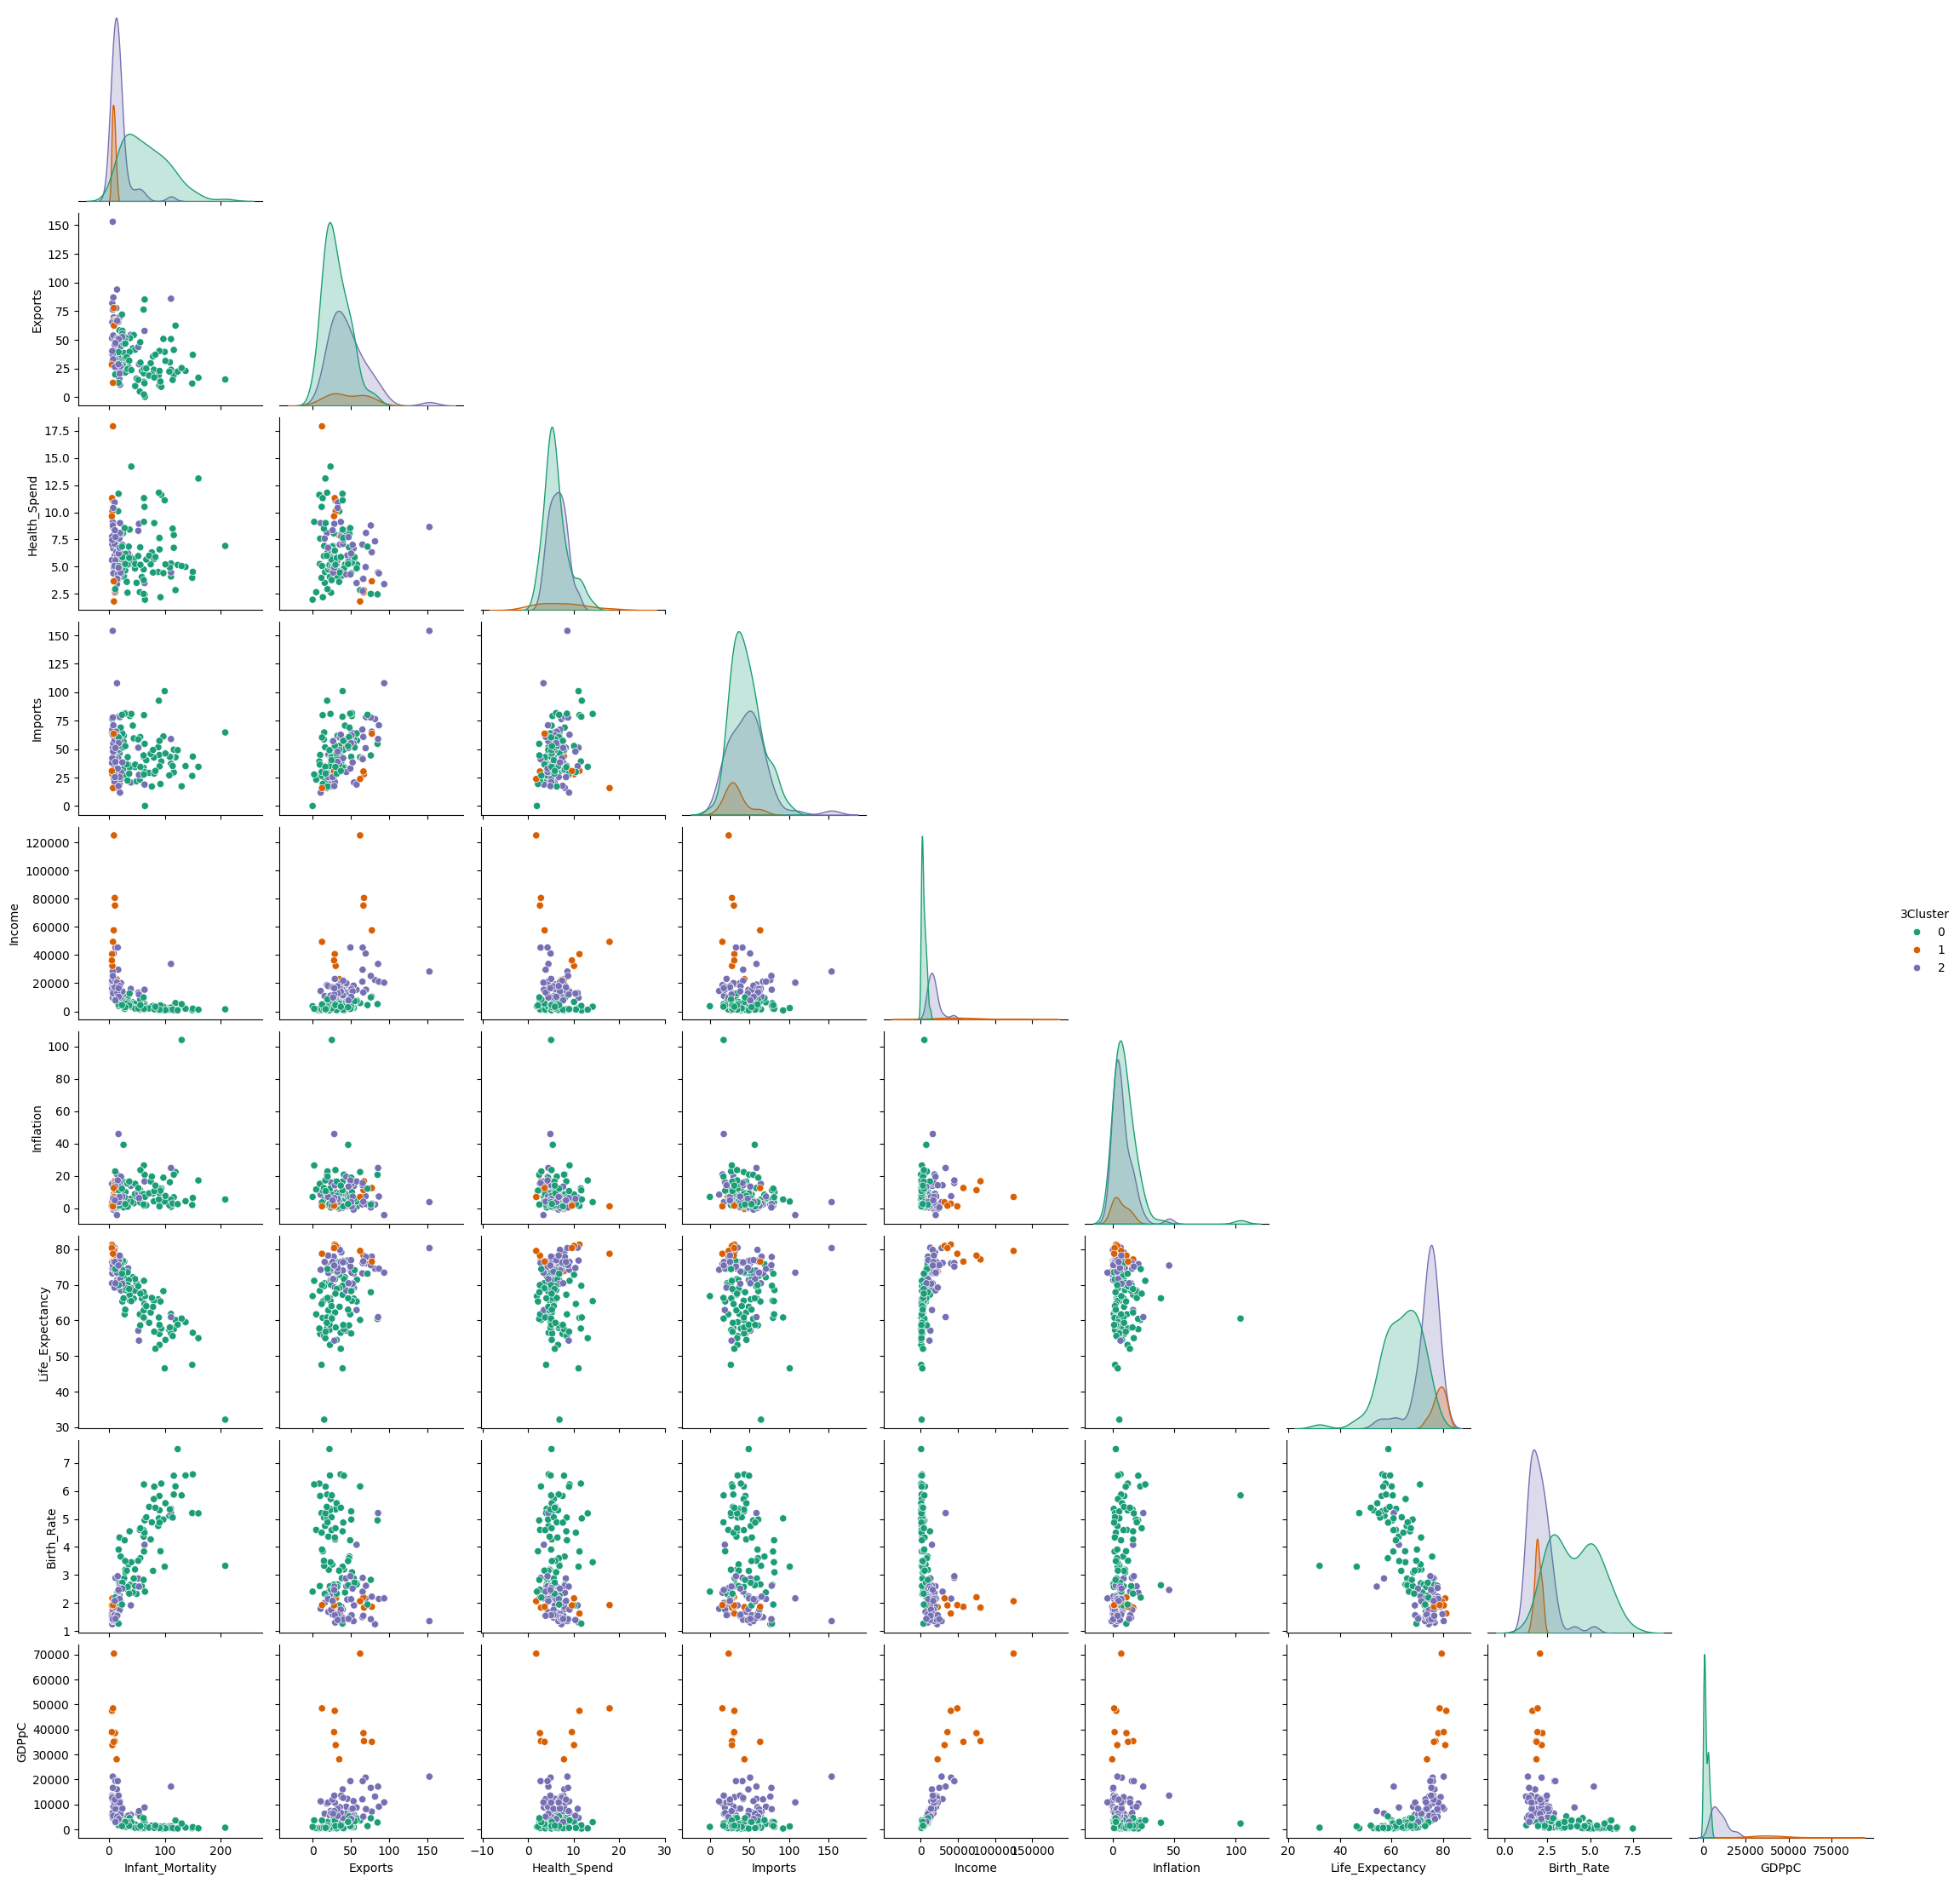

In [60]:
# Pairwise plot (Seaborn) of features colour-coded by predicted cluster

pairplot(countries_df1, palette='Dark2', hue='3Cluster', diag_kind='kde', corner=True);

<div class="alert alert-block alert-info">
<h3>GDP, income, birth rate and life expectancy cluster quite well.<h3>

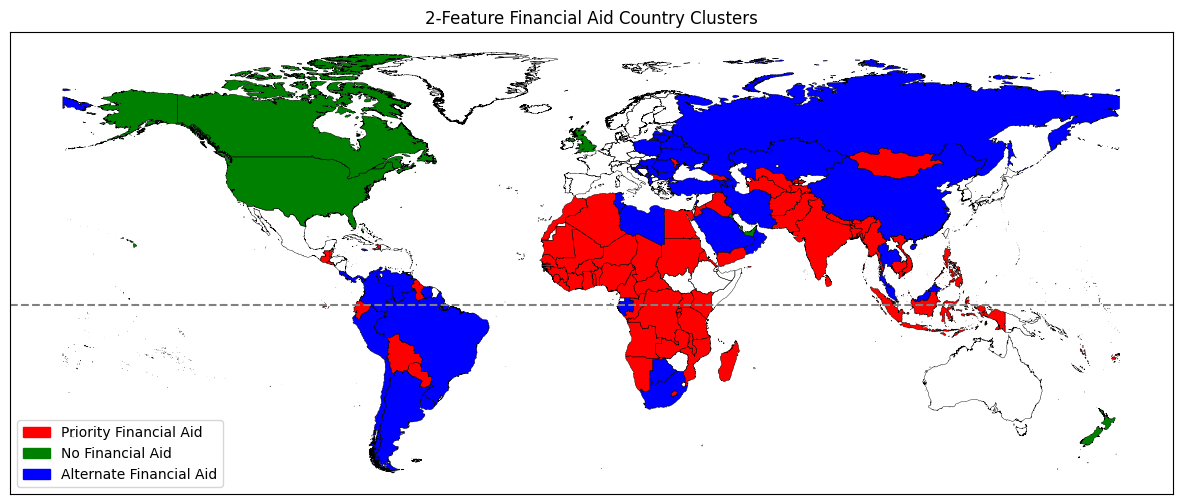

In [61]:
# Show worst/best ranked countries on world map

fig, ax = subplots(figsize=(15,15))

world_map.boundary.plot(linewidth=0.3, edgecolor='k', ax=ax)
ax.axhline(0, linestyle='--', c='gray')
ax.set_title(f'2-Feature Financial Aid Country Clusters')
ax.set_xticks([])
ax.set_yticks([])
# ax.axis('off')
world_map[world_map['NAME'].isin(cluster0_countries)].plot(color='r', ax=ax)
world_map[world_map['NAME'].isin(cluster1_countries)].plot(color='g', ax=ax)
world_map[world_map['NAME'].isin(cluster2_countries)].plot(color='b', ax=ax)

# .legend() does not support handles for Axes instances (i.e. ax=ax), so need 'proxy artist': https://matplotlib.org/stable/users/explain/axes/legend_guide.html#proxy-legend-handles
cluster0 = Patch(color='r', label='Priority Financial Aid')
cluster1 = Patch(color='g', label='No Financial Aid')
cluster2 = Patch(color='b', label='Alternate Financial Aid')
ax.legend(handles=[cluster0, cluster1, cluster2], loc='lower left')

show()

<div class="alert alert-block alert-info">
Some countries appear blank because they were not present or pruned/removed from the dataset.

# KMeans for X_all

In [62]:
k = 3
km = KMeans(n_clusters=k, random_state=RS)

cluster_pred_all = km.fit_predict(X_all_rob_scaled)  # Predict the 3 clusters for X_all
cluster_pred_all

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [63]:
# Add predicted clusters to 'countries_df1' which has all the original features

countries_df1['3Cluster'] = cluster_pred_all
print(len(countries_df1))
countries_df1

141


/var/folders/8c/bf334cs149s9dwx169yz6k700000gn/T/ipykernel_87150/4232145682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countries_df1['3Cluster'] = cluster_pred_all


Country  Infant_Mortality  Exports  Health_Spend  Imports  \
0            Afghanistan              90.2     10.0          7.58     44.9   
1                Albania              16.6     28.0          6.55     48.6   
2                Algeria              27.3     38.4          4.17     31.4   
3                 Angola             119.0     62.3          2.85     42.9   
4    Antigua and Barbuda              10.3     45.5          6.03     58.9   
..                   ...               ...      ...           ...      ...   
162              Vanuatu              29.2     46.6          5.25     52.7   
163            Venezuela              17.1     28.5          4.91     17.6   
164              Vietnam              23.3     72.0          6.84     80.2   
165                Yemen              56.3     30.0          5.18     34.4   
166               Zambia              83.1     37.0          5.89     30.9   

     Income  Inflation  Life_Expectancy  Birth_Rate  GDPpC  3Cluster  
0      1610       9.44             56.2        5.82    553         0  
1      9930       4.49             76.3        1.65   4090         0  
2     12900      16.10             76.5        2.89   4460         0  
3      5900      22.40             60.1        6.16   3530         0  
4     19100       1.44             76.8        2.13  12200         0  
..      ...        ...              ...         ...    ...       ...  
162    2950       2.62             63.0        3.50   2970         0  
163   16500      45.90             75.4        2.47  13500         0  
164    4490      12.10             73.1        1.95   1310         0  
165    4480      23.60             67.5        4.67   1310         0  
166    3280      14.00             52.0        5.40   1460         0  

[141 rows x 11 columns]

In [64]:
# '0' cluster countries

countries_df1[countries_df1['3Cluster'] == 0]

Country  Infant_Mortality  Exports  Health_Spend  Imports  \
0            Afghanistan              90.2     10.0          7.58     44.9   
1                Albania              16.6     28.0          6.55     48.6   
2                Algeria              27.3     38.4          4.17     31.4   
3                 Angola             119.0     62.3          2.85     42.9   
4    Antigua and Barbuda              10.3     45.5          6.03     58.9   
..                   ...               ...      ...           ...      ...   
162              Vanuatu              29.2     46.6          5.25     52.7   
163            Venezuela              17.1     28.5          4.91     17.6   
164              Vietnam              23.3     72.0          6.84     80.2   
165                Yemen              56.3     30.0          5.18     34.4   
166               Zambia              83.1     37.0          5.89     30.9   

     Income  Inflation  Life_Expectancy  Birth_Rate  GDPpC  3Cluster  
0      1610       9.44             56.2        5.82    553         0  
1      9930       4.49             76.3        1.65   4090         0  
2     12900      16.10             76.5        2.89   4460         0  
3      5900      22.40             60.1        6.16   3530         0  
4     19100       1.44             76.8        2.13  12200         0  
..      ...        ...              ...         ...    ...       ...  
162    2950       2.62             63.0        3.50   2970         0  
163   16500      45.90             75.4        2.47  13500         0  
164    4490      12.10             73.1        1.95   1310         0  
165    4480      23.60             67.5        4.67   1310         0  
166    3280      14.00             52.0        5.40   1460         0  

[127 rows x 11 columns]

In [65]:
cluster0_countries = countries_df1['Country'][countries_df1['3Cluster'] == 0].values
print(len(cluster0_countries))
cluster0_countries

127


array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Azerbaijan',
       'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Cape Verde', 'Central African Rep.', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Dem. Rep. Congo', 'Congo', 'Costa Rica',
       "Côte d'Ivoire", 'Croatia', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Fiji',
       'Gabon', 'Gambia', 'Georgia', 'Ghana', 'Grenada', 'Guatemala',
       'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Hungary', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Jamaica', 'Jordan', 'Kazakhstan',
       'Kenya', 'Kiribati', 'Kyrgyz Republic', 'Lao', 'Latvia', 'Lebanon',
       'Lesotho', 'Liberia', 'Libya', 'Lithuania', 'Macedonia, FYR',
       'Madagascar', 'Malawi'

In [66]:
# '1' cluster countries

countries_df1[countries_df1['3Cluster'] == 1]

Country  Infant_Mortality  Exports  Health_Spend  Imports  \
10           Bahamas              13.8     35.0          7.89     43.7   
29            Canada               5.6     29.1         11.30     31.0   
98             Malta               6.8    153.0          8.65    154.0   
111      New Zealand               6.2     30.3         10.10     28.0   
134  Slovak Republic               7.0     76.3          8.79     77.8   
158   United Kingdom               5.2     28.2          9.64     30.8   
159    United States               7.3     12.4         17.90     15.8   

     Income  Inflation  Life_Expectancy  Birth_Rate  GDPpC  3Cluster  
10    22900     -0.393             73.8        1.86  28000         1  
29    40700      2.870             81.3        1.63  47400         1  
98    28300      3.830             80.3        1.36  21100         1  
111   32300      3.730             80.9        2.17  33700         1  
134   25200      0.485             75.5        1.43  16600         1  
158   36200      1.570             80.3        1.92  38900         1  
159   49400      1.220             78.7        1.93  48400         1

In [67]:
cluster1_countries = countries_df1['Country'][countries_df1['3Cluster'] == 1].values

# Change 'United States' to 'United States of America' for consistency with geopandas (mapping)
cluster1_countries[-1] = 'United States of America'

# Verify change
print(len(cluster1_countries))
cluster1_countries

7


array(['Bahamas', 'Canada', 'Malta', 'New Zealand', 'Slovak Republic',
       'United Kingdom', 'United States of America'], dtype=object)

In [68]:
# '2' cluster countries

countries_df1[countries_df1['3Cluster'] == 2]

Country  Infant_Mortality  Exports  Health_Spend  Imports  \
11                Bahrain               8.6     69.5          4.97     50.9   
23                 Brunei              10.5     67.4          2.84     28.0   
82                 Kuwait              10.8     66.7          2.63     30.4   
115                  Oman              11.7     65.7          2.77     41.2   
123                 Qatar               9.0     62.3          1.81     23.8   
128          Saudi Arabia              15.7     49.6          4.29     33.0   
157  United Arab Emirates               8.6     77.7          3.66     63.6   

     Income  Inflation  Life_Expectancy  Birth_Rate  GDPpC  3Cluster  
11    41100       7.44             76.0        2.16  20700         2  
23    80600      16.70             77.1        1.84  35300         2  
82    75200      11.20             78.2        2.21  38500         2  
115   45300      15.60             76.1        2.90  19300         2  
123  125000       6.98             79.5        2.07  70300         2  
128   45400      17.20             75.1        2.96  19300         2  
157   57600      12.50             76.5        1.87  35000         2

In [69]:
cluster2_countries = countries_df1['Country'][countries_df1['3Cluster'] == 2]
print(len(cluster2_countries))
cluster2_countries

7


11                  Bahrain
23                   Brunei
82                   Kuwait
115                    Oman
123                   Qatar
128            Saudi Arabia
157    United Arab Emirates
Name: Country, dtype: object

In [70]:
# Group by clusters and inspect feature means

countries_df1.groupby(countries_df1['3Cluster']).mean(numeric_only=True)

Infant_Mortality    Exports  Health_Spend    Imports        Income  \
3Cluster                                                                       
0                48.546457  35.631488      6.300472  45.593432   8524.905512   
1                 7.414286  52.042857     10.610000  54.442857  33571.428571   
2                10.700000  65.557143      3.281429  38.700000  67171.428571   

          Inflation  Life_Expectancy  Birth_Rate         GDPpC  
3Cluster                                                        
0          9.206724        67.694488    3.305276   4362.314961  
1          1.901714        78.685714    1.757143  33442.857143  
2         12.517143        76.928571    2.287143  34057.142857

<div class="alert alert-block alert-info">
<h3>Cluster '0' has significantly worse mean infant mortality, exports, income, life expectancy, birth rate and GDP - priority countries for financial aid.<br>

Cluster '1' & cluster '2' are more similar to each other than to cluster '0'. The higher infant mortality and lower health spend of cluster '2' compared to cluster '1' makes it more the alternate financial aid countries, with cluster '1' countries receiving no financial aid.<h3>

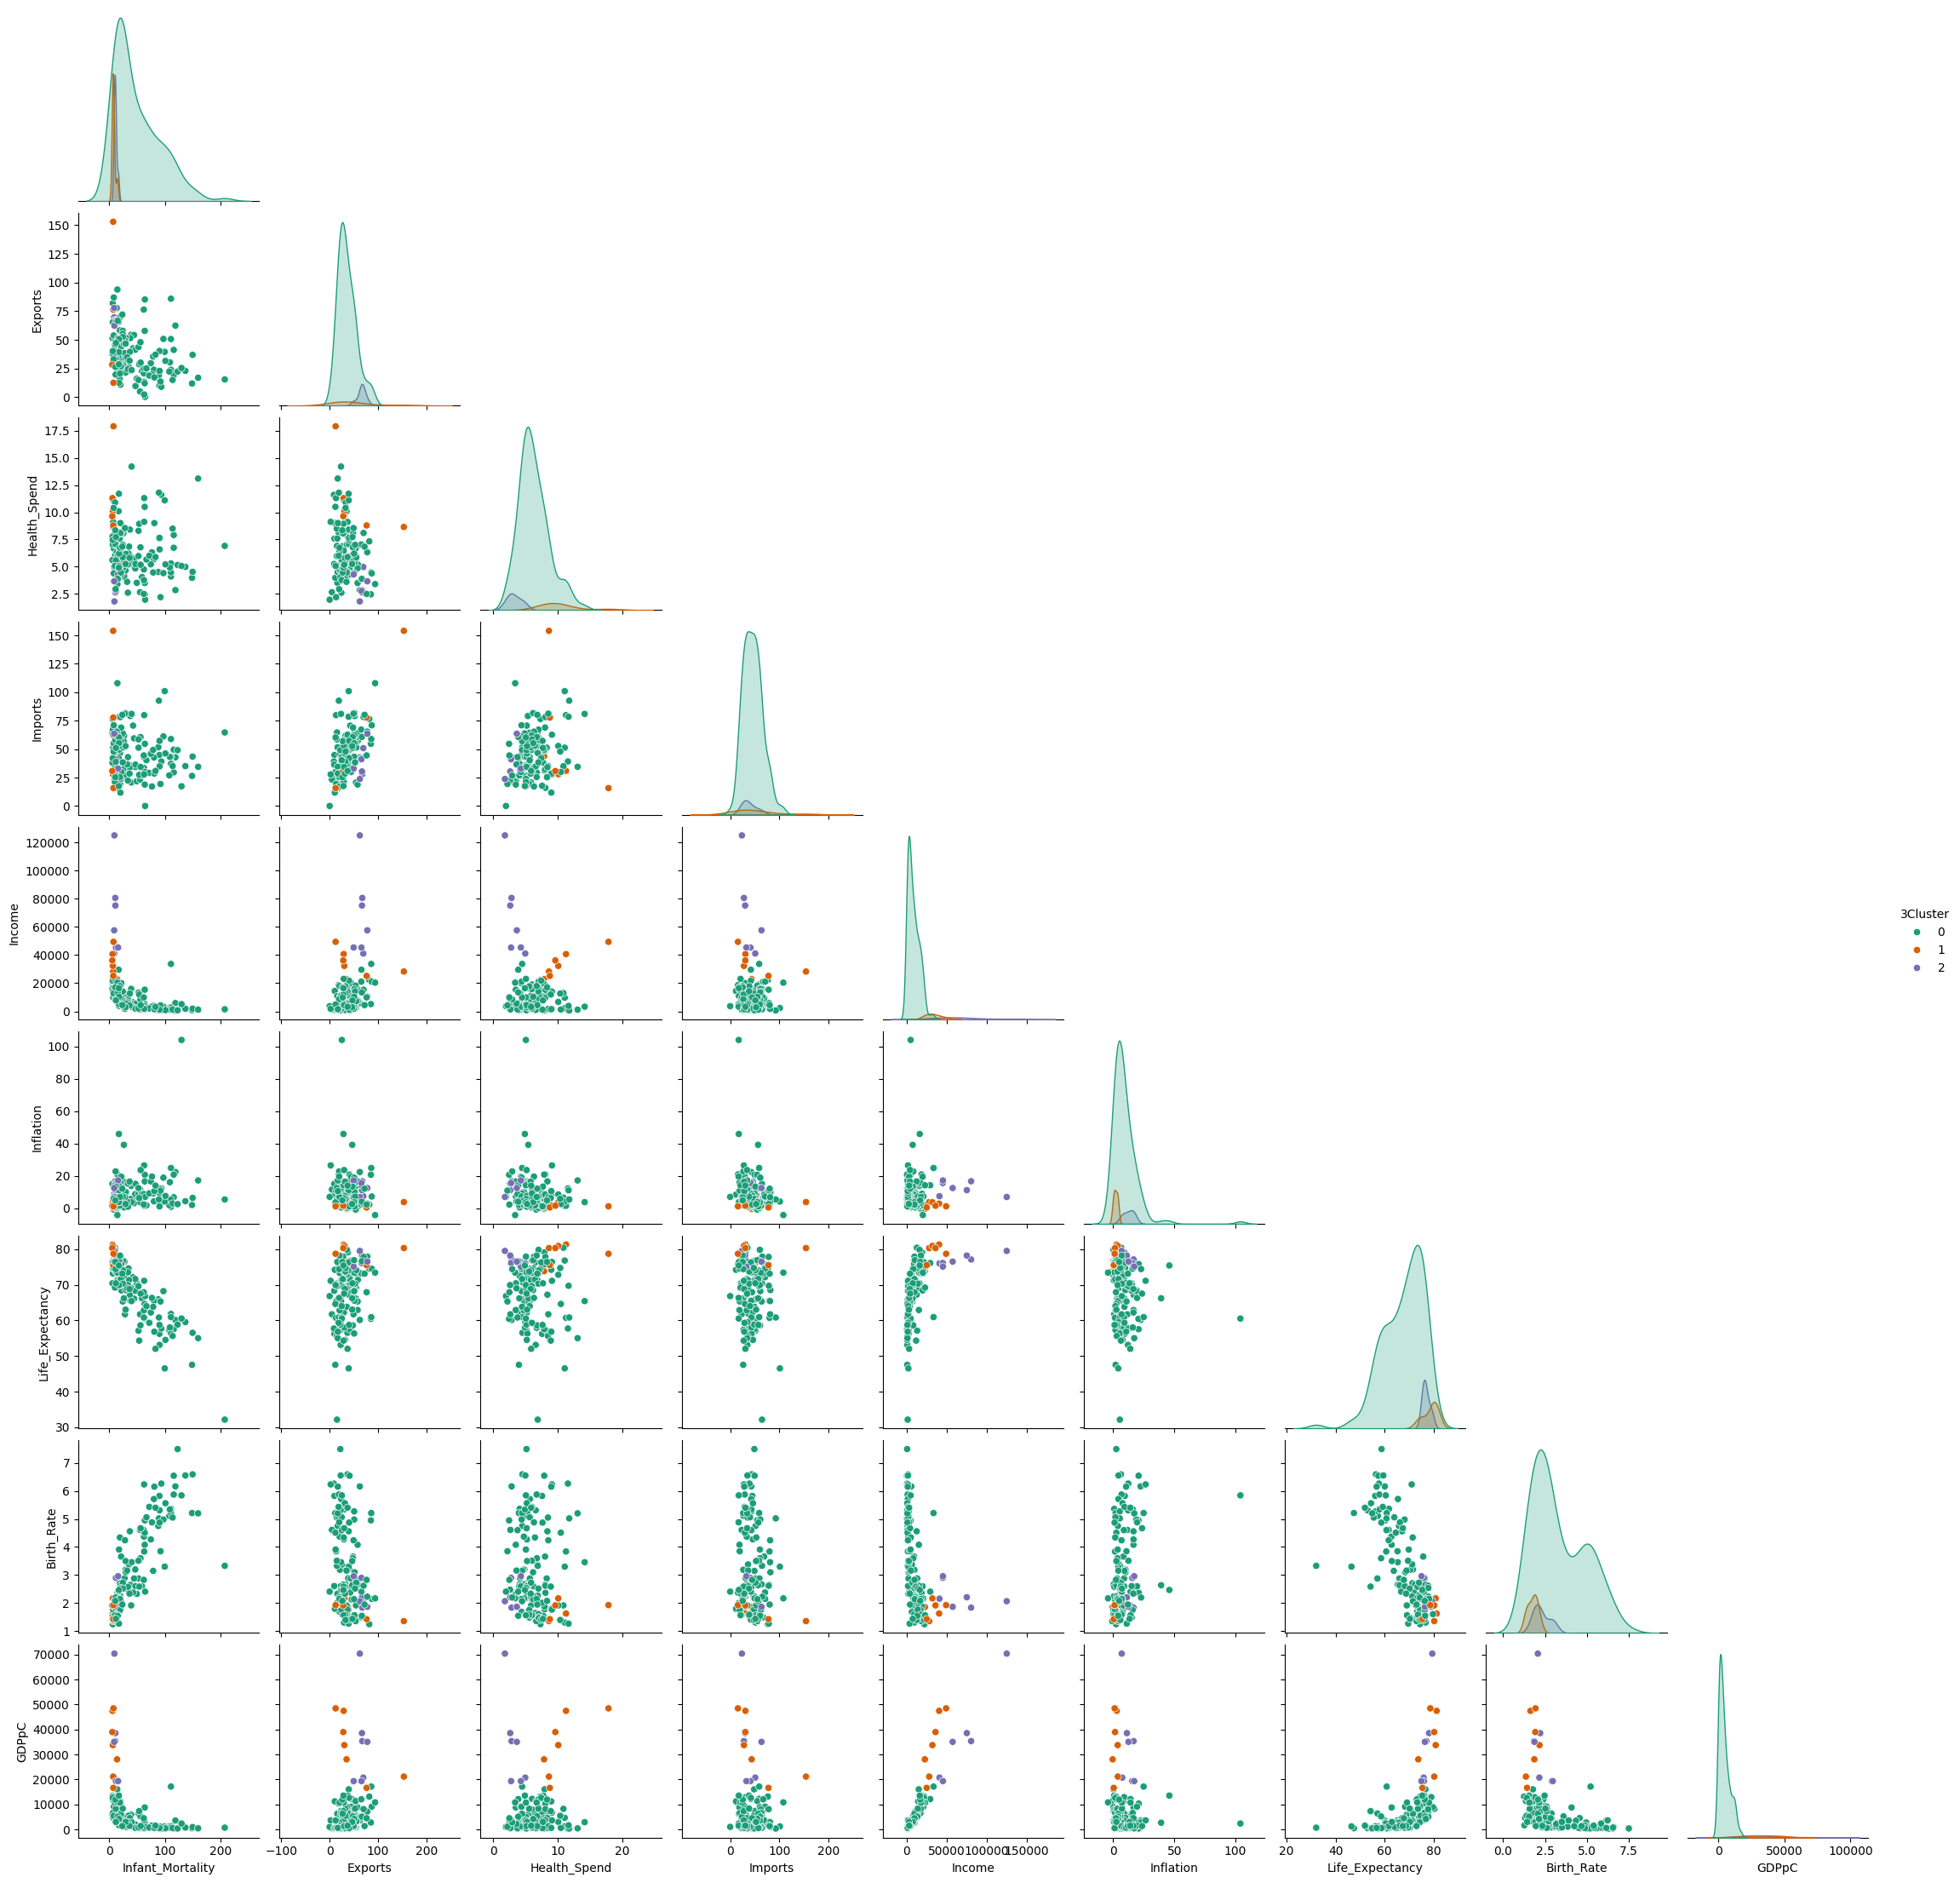

In [71]:
# Pairwise plot (Seaborn) of features colour-coded by predicted cluster

pairplot(countries_df1, palette='Dark2', hue='3Cluster', diag_kind='kde', corner=True);

<div class="alert alert-block alert-info">
<h3>The clusters are less balanced (<i>i.e.</i>, many more samples in cluster '0' than clusters '1' & '2') than when using X_2.<h3>

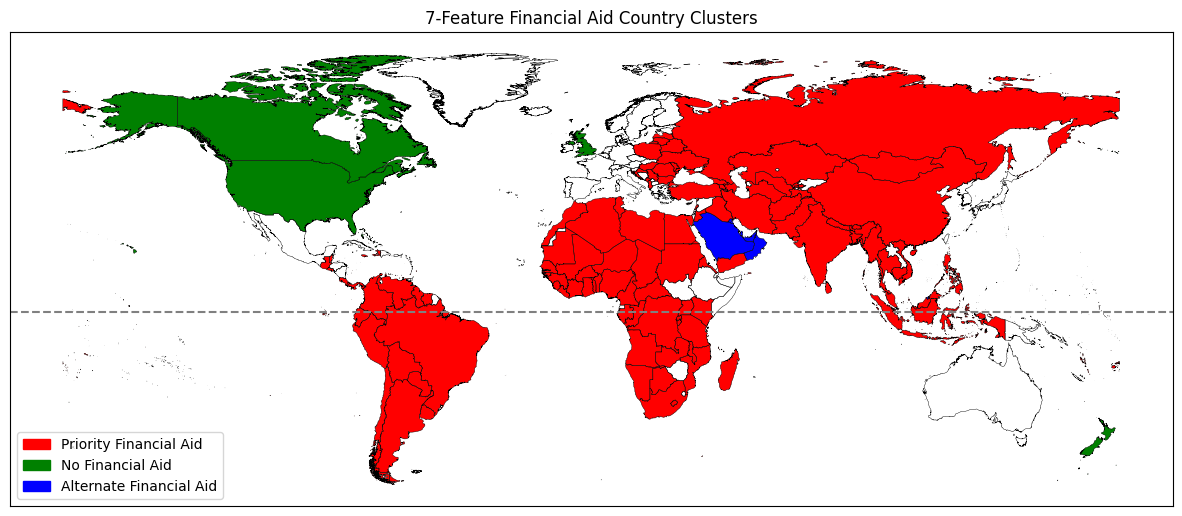

In [72]:
# Show worst/best ranked countries on world map

fig, ax = subplots(figsize=(15,15))

world_map.boundary.plot(linewidth=0.3, edgecolor='k', ax=ax)
ax.axhline(0, linestyle='--', c='gray')
ax.set_title(f'7-Feature Financial Aid Country Clusters')
ax.set_xticks([])
ax.set_yticks([])
# ax.axis('off')
world_map[world_map['NAME'].isin(cluster0_countries)].plot(color='r', ax=ax)
world_map[world_map['NAME'].isin(cluster1_countries)].plot(color='g', ax=ax)
world_map[world_map['NAME'].isin(cluster2_countries)].plot(color='b', ax=ax)

# .legend() does not support handles for Axes instances (i.e. ax=ax), so need 'proxy artist': https://matplotlib.org/stable/users/explain/axes/legend_guide.html#proxy-legend-handles
cluster0 = Patch(color='r', label='Priority Financial Aid')
cluster1 = Patch(color='g', label='No Financial Aid')
cluster2 = Patch(color='b', label='Alternate Financial Aid')
ax.legend(handles=[cluster0, cluster1, cluster2], loc='lower left')

show()

<div class="alert alert-block alert-info">
<h3>There are 127 countries (90%) classed as Priority Financial Aid when using 7 features (X_all) compared to 78 countries (55%) when using just two features (GDPpC & Birth_Rate; X_2).<br>

Therefore, using only two features for KMeans clustering yields a more interpretable and manageable result to facilitate decisions on financial aid distribution for infant health.<br>

This analysis can be used as a first step in refining which countries are in urgent need of financial aid by performing further analyses on the Priority Financial Aid (cluster '0') countries.<h3>

Further analyses...

# Hierarchical Clustering

# DBSCAN Clustering